---
# Apples to Apples
### John Thurman
---

## Table of Contents
* #### [Introduction](#Introduction)
    * [Define functions](#DefineFunctions)
    * [Loading Data](#LoadingData)
    * [Data exploration](#DataExploration)
* #### [Modelling fruit 360 data](#ModellingSection1)
    * [Random Forest Benchmark](#Benchmark)
    * [2 Convolution CNN](#Model1)
    * [4 Convolution CNN](#Model2)
    * [Transfer learning](#Model3)
    * [General Comments](#Comments1)
* #### [Modelling flickr data](#ModellingSection2)
    * [4 Convolution CNN](#Model4)
    * [Transfer learning](#Model5)
    * [General Comments](#Comments2)
* #### [Reduced fruit subset](#ModellingSection3)
    * [4 Convolutions CNN](#Model6)
    * [Transfer learning](#Model7)
    * [Hyper-parameter tuning](#Hyperparam)
    * [General Comments](#Comments3)
    * [Image Augmentation](#ImageAugmentation)

Load the appropriate libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import pickle
import os
import glob
from collections import Counter

from keras import backend as K
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import top_k_categorical_accuracy, sparse_top_k_categorical_accuracy
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.utils import class_weight

print('Tensorflow version \t:', tf.__version__)
print(tf.test.is_gpu_available(), tf.test.is_built_with_cuda(), tf.test.gpu_device_name())

Using TensorFlow backend.
W0330 18:30:25.567649 17164 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


Tensorflow version 	: 1.10.0
True True /device:GPU:0


<a id="Introduction"> </a>
# Introduction

The objective of this project is to determine whether image classification techniques can be used to distinguish between different types of fruit. The project looks at 4 general types of model:
* Random Forest Classifier (Used as a benchmark)
* A Convoltional Neural network (CNN) with 2 convolutional layers
* CNN with 4 convolutional layers
* CNN using transfer learning from a mobilenet (V2) model that has been trained on the Imagenet dataset.

The data used for this project has come from two sources:
* 'fruit-360' dataset produced by Horea Muresan, Mihai Oltean, and available at kaggle 
<a href='https://www.kaggle.com/moltean/fruits'> here </a> 
* A dataset that was compiled using the Flickr API with additional manual cleaning. A separate jupyter notebook has been included detailing the steps taken to collect this data

This project has been split into two sections, seperated by the two of data sources

<a id="DefineFunctions"></a>
# Defining useful functions 

These functions are used throughout the document in the analysis

In [2]:
# Metric for defining success. In addition to accuracy, this metric considers it a sucess if the correct label is amongst
# the top 4 predictions.
def custom_accuracy(ytrue, ypred):
    '''
    An accuracy where we determine whether we manage to guess the product within the top 4 tries.
    '''
    return sparse_top_k_categorical_accuracy(ytrue, ypred, k=4)

# functions for plotting learning curves, accuracy and the custom accuracy
def plt_history(history):
    '''
    For use with a keras based model.
    This model will plot the loss, accuracy and 'top4 accuracy' per epoch.
    '''
    
    plt.figure(figsize=[20,6]);
    for counter, metric in enumerate(['loss', 'acc', 'custom_accuracy']):
    
        val_metric = 'val_'+metric
        plt.subplot(1,3,counter+1)
        plt.plot(history.history[metric],'r',linewidth=3.0);
        plt.plot(history.history[val_metric],'b',linewidth=3.0);
        plt.legend(['Training '+ metric, 'Validation '+metric,],fontsize=18);
        plt.xlabel('Epochs ',fontsize=16);
        plt.ylabel(metric ,fontsize=16);
        plt.title(metric +' Curves',fontsize=16);   


def plot_first_group(data, prediction_labels, truth_labels, number=15):
    '''
    This draws the first n images
    '''
    plt.figure(figsize=(20,10))
    for count, photo in enumerate(prediction_labels[:number]):
        rows = (number-1)//5+1
        plt.subplot(rows,5, count+1)
        b,g,r = cv2.split(data[count,:,:,:])       
        rgb_img = cv2.merge([r,g,b]) 
        plt.imshow(rgb_img)
        plt.title(photo+'({}) ' .format(truth_labels[count]))
        
        
def load_data(directory, maxData=None, randomState=1):
    '''
    Loads the different data sets from file. Smaller (random) subsets can be taken for experimenting by using the MaxData and 
    random state parameters
    '''
    #Get list of all images in directory
    imagePaths = glob.glob(directory+'/*/*.jpg', recursive=True)
    
    if maxData is not None:
        np.random.set_state=randomState
        imagePaths = np.random.choice(imagePaths,size=maxData)
          
    X =[]
    y =[]
    for path in imagePaths:
        label = path.split("\\")[-2]
        image = cv2.imread(path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        X.append(image)
        y.append(label)
        
    return np.array(X), np.array(y)

def classification_report_as_df(labels_true, labels_predict):
    cr = classification_report(labels_true, labels_predict)
    results=[]
    for row in cr.split('\n')[2:-5]:
        results.append([row[:14]]+row[15:].split('      ')[1:])

    results = pd.DataFrame(results, columns=['Fruit', 'Precision', 'Recall', 'F1 score','Support'],dtype=np.float64)
    #results.iloc[:,1:] = results.iloc[:,1:].values.astype(np.float64)
    return results

<a id='LoadingData'></a>
# Load data

The three datasets that are used for this project are loaded in the following sections. Note that maxData has been set to 20,000 for the fruit360 dataset. A small improvement in the results may be possible using the full dataset. Given that the fruit 360 dataset is not used in the final model, I have decided to include only a proportion of the data in this notebook.
### Fruit 360 data set

In [3]:
# Load training set
X_train,y_train = load_data('./data/fruits/fruits-360/Training',maxData=20000)

#Preprocess the data using a label encoder and diving by 255
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
X_train = X_train/255
y_train = label_encoder.transform(y_train)

# Save the label encoder to file
fileObject = open('./label_encoders/labelEncoding.pkl','wb')
pickle.dump(label_encoder,fileObject)
fileObject.close()

In [4]:
# test data is a hold out set specificly identified in the data set. Load this data and preprocess
X_test,y_test = load_data('./data/fruits/fruits-360/Test', maxData=10000)
X_test = X_test/255
y_test = label_encoder.transform(y_test)

In [5]:
INPUTSHAPE = (100,100,3)
OUTPUTSHAPE = len(np.unique(y_train))

### Flickr data

Two sets of flickr The Flickr data is loaded in full and also it is loaded as just the top 11 fruit. Note that the test and training set uses stratified sampling due to the small number of images in certain categories

In [6]:
# load data
X_flickr, y_flickr = load_data('./data/flickr')
X_flickr = X_flickr/255

#Create the reduced dataset:
fruitsubset = ['Strawberry', 'Apple', 'Lemon', 'Orange', 'Mango', 'Banana', 'Grape', 'Passion Fruit', 'Peach', 'Pineapple', 'Lime']
# returns true for each row that is in the fruitsubset list
infruitsubset = np.in1d(y_flickr, fruitsubset)
X_flickr_subset = X_flickr[infruitsubset]
y_flickr_subset = y_flickr[infruitsubset]

#need a new encoder as the data has different labels than the fruit 360 dataset
label_encoder_flickr = LabelEncoder()

#transformation on data
y_flickr = label_encoder_flickr.fit_transform(y_flickr)
X_flickr_train, X_flickr_test, y_flickr_train, y_flickr_test = train_test_split(X_flickr, y_flickr,  \
                                                                                test_size=0.1, train_size=0.9, stratify=y_flickr)
# Save the label encoder to use in predictions in a web app
fileObject = open('./label_encoders/labelEncodingFlickr.pkl','wb')
pickle.dump(label_encoder_flickr,fileObject)
fileObject.close()

#Output shape for the modelling params
OUTPUTSHAPEFLICKR = len(np.unique(y_flickr))

In [7]:
#need a new encoder as the data has different labels than the fruit 360 dataset (and smaller than the other flickr encoding)
label_encoder_flickr_subset = LabelEncoder()

#transformation on data
y_flickr_subset = label_encoder_flickr_subset.fit_transform(y_flickr_subset)
X_flickr_subset_train, X_flickr_subset_test, y_flickr_subset_train, y_flickr_subset_test = train_test_split(X_flickr_subset, y_flickr_subset,  test_size=0.1, train_size=0.9, stratify=y_flickr_subset)

# Save the label encoder to use in predictions in a web app
fileObject = open('./label_encoders/labelEncodingFlickrSubset.pkl','wb')
pickle.dump(label_encoder_flickr_subset,fileObject)
fileObject.close()

#Output shape for the modelling params
OUTPUTSHAPEFLICKRSUBSET = len(np.unique(y_flickr_subset))

#To free up space as otherwise there is a duplication of this data
del X_flickr, y_flickr

The flickr data includes class imbalances. The sklearn 'class weights' class has been used to calculate relevant weights to rebalance the classes.

In [8]:
class_weights_flickr = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_flickr_train),
                                                 y_flickr_train)

class_weights_flickr_subset = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_flickr_subset_train),
                                                 y_flickr_subset_train)

# Data Exploration <a id='DataExploration'></a>

## Categories in the data
### Fruit 360 dataset

The following is a bar chart indicating the number of images of each class. The number ranges from around 100 to around 400 but with the vast majority of classes having around 200 images. This does not indicate a problem with significant class imbalances

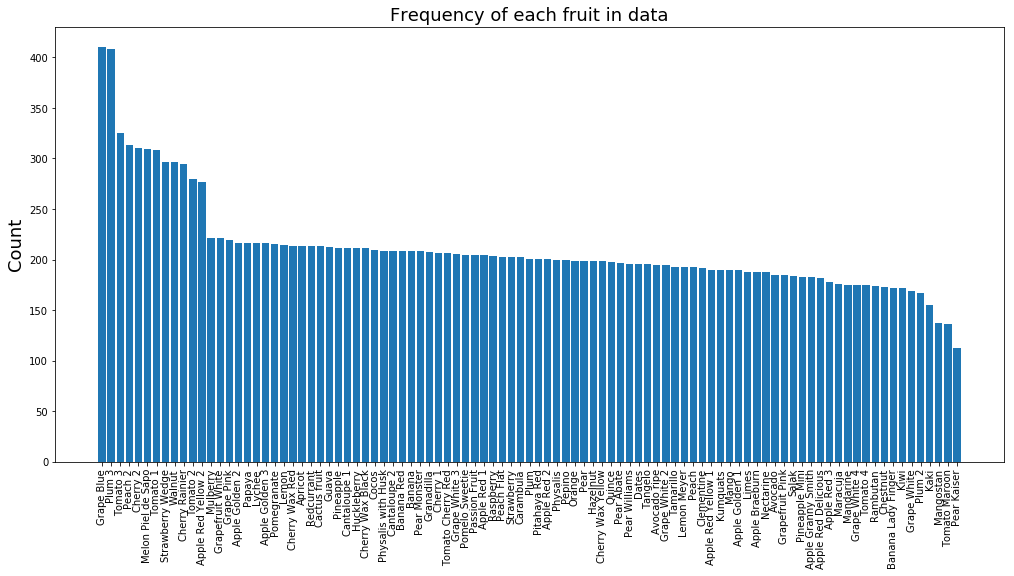

In [9]:
count = Counter(y_train)
df = pd.DataFrame([count.keys(), count.values()], index=['Fruit Number', 'Count'])
df = df.transpose()
df['Fruit'] = label_encoder.inverse_transform(df['Fruit Number'].values)
df = df.sort_values('Count', ascending=False)

plt.figure(figsize=(17,8))
plt.bar(df['Fruit'], df['Count'])
plt.xticks(rotation=90);
plt.title("Frequency of each fruit in data", size=18);
plt.ylabel('Count', size=18);

### Flickr dataset

In contrast to the fruit 360 dataset, there are a number of classes with very few images - around 20, compared to the largest classes having over 500 images. The most popular classes have 25x more data than the least popular. It is worth noting that this as this could lead to some issues that are related to imbalanced datasets, such as poor recall and precision scores with reasonable accuracy.

Note that the most popular fruits have more than 120 fruits, limiting the difference in data to around 5x the number of images. Class imbalance should be less problematic in this scenario.

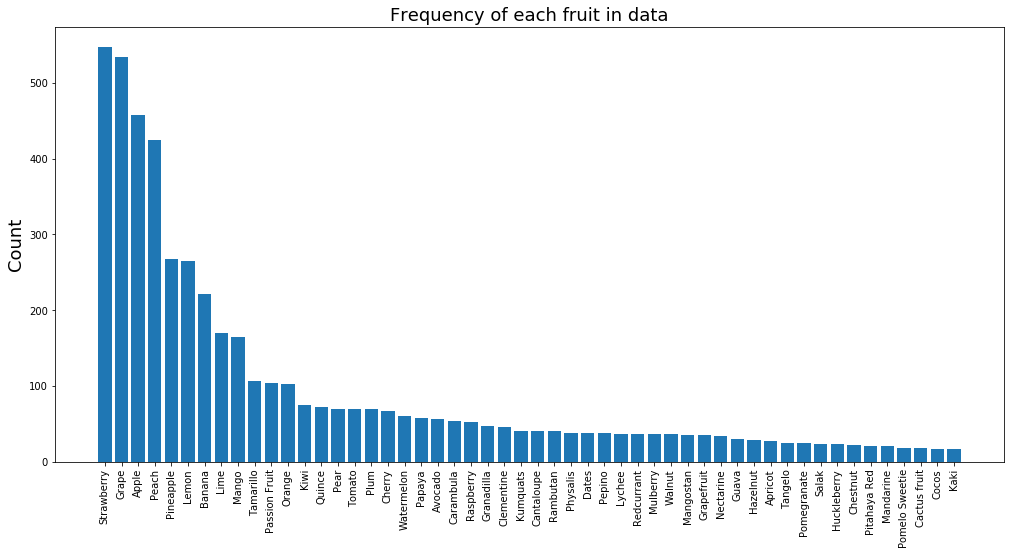

In [10]:
count = Counter(y_flickr_train)
df = pd.DataFrame([count.keys(), count.values()], index=['Fruit Number', 'Count'])
df = df.transpose()
df['Fruit'] = label_encoder_flickr.inverse_transform(df['Fruit Number'].values)
df = df.sort_values('Count', ascending=False)

plt.figure(figsize=(17,8))
plt.bar(df['Fruit'], df['Count'])
plt.xticks(rotation=90);
plt.title("Frequency of each fruit in data", size=18);
plt.ylabel('Count', size=18);

### Example images

The fruit 360 dataset has been preprocessed to remove the background and increase the size of the fruit to cover the full array. 

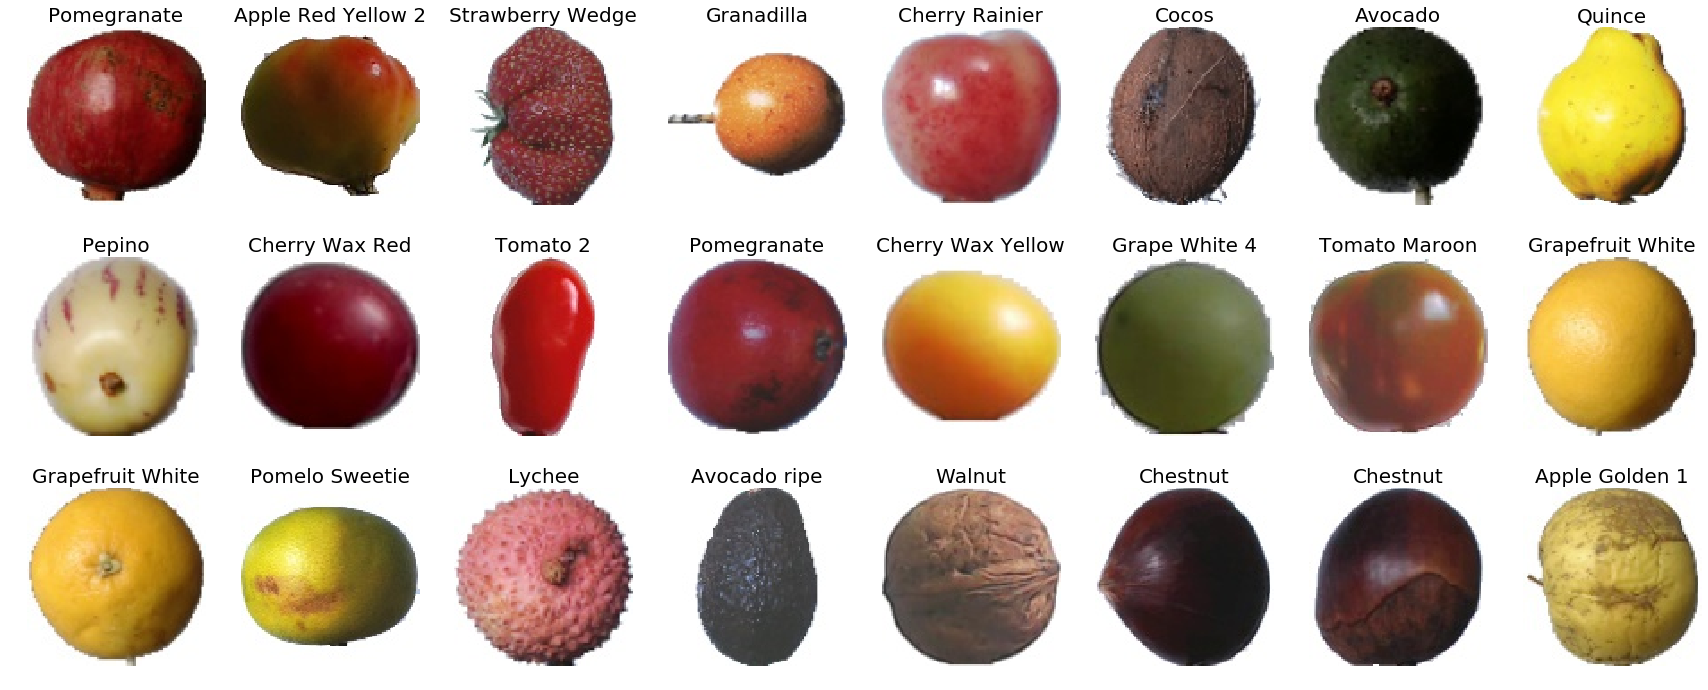

In [11]:
#Fruit 360
y_train_label = label_encoder.inverse_transform(y_train)
plt.figure(figsize=(30,12))
for i in range(24):
    plt.subplot(3,8,i+1)
    plt.imshow(X_train[i,:,:,:])
    plt.title(y_train_label[i], size = 20)
    plt.axis('off')

The Flickr dataset includes a large variety of images with multiple fruit in some images, different varieties under the same label (e.g. Both Yellow mango and green mango have been included under the Mango class). Due to the heterogeneity of the data there may be significant difficulties in classifying these images.

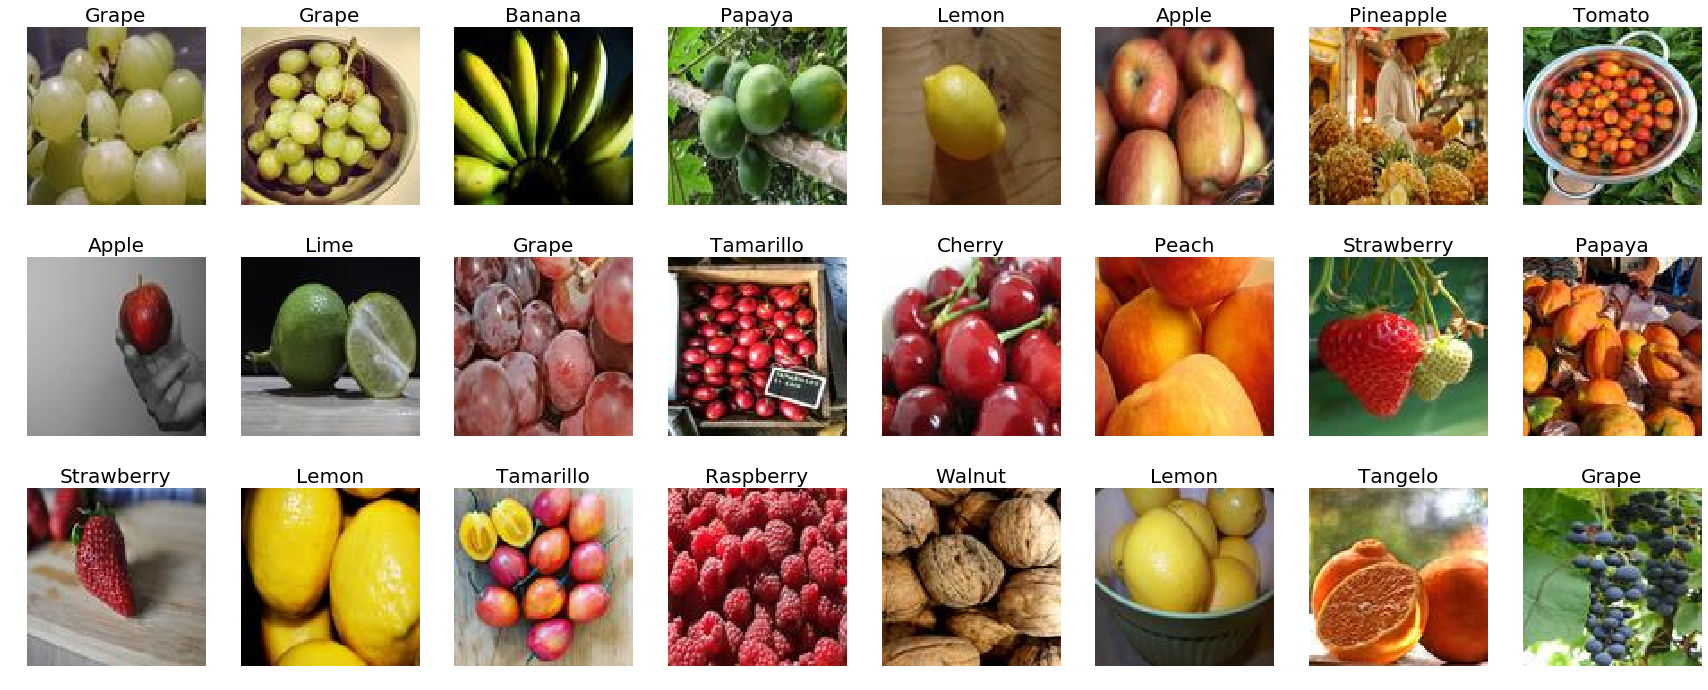

In [12]:
#Flickr data
y_flickr_train_label = label_encoder_flickr.inverse_transform(y_flickr_train)
plt.figure(figsize=(30,12))
for i in range(24):
    plt.subplot(3,8,i+1)
    plt.imshow(X_flickr_train[i,:,:,:])
    plt.title(y_flickr_train_label[i], size = 20)
    plt.axis('off')

### Principal Component Analysis

The principal components of the images have been calculatd below, for each dataset

In [13]:
X_train_flat = X_train.reshape(len(X_train),-1)
pca = PCA(n_components=10)
pca_fruit360 = pca.fit_transform(X_train_flat)

The first 10 Principal Components extracted from the fruit 360 data set are shown below. The pixels at the edges are not used, whilst the principal components appear to distinguish more on colour and colour gradient than on any structure

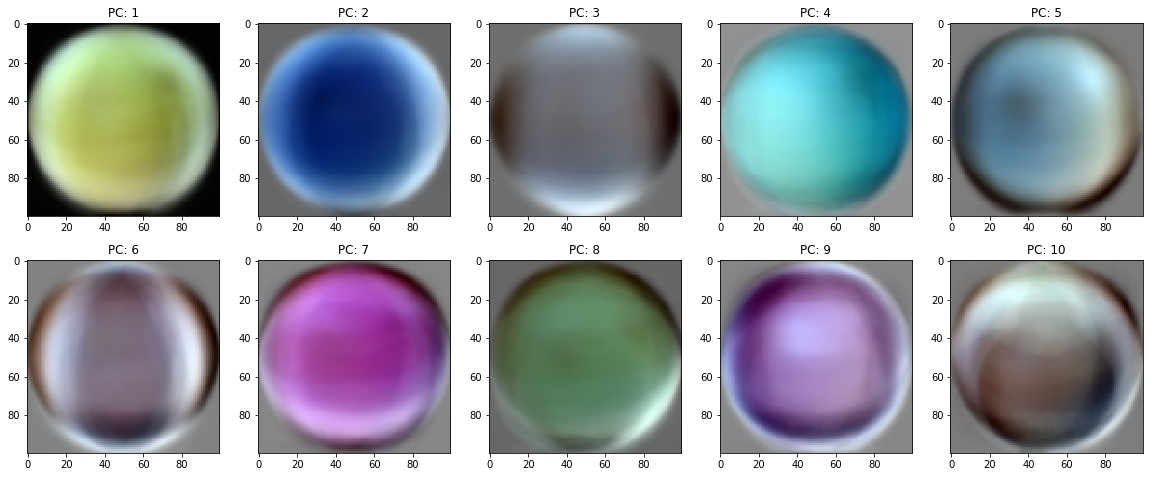

In [14]:
plt.figure(figsize=(20,8))

for count, component in enumerate(pca.components_[:10]):
    plt.subplot(2,5,count+1)
    mincomp = np.min(component)
    maxcomp = np.max(component)
    
    image = (255*(component-mincomp)/(maxcomp-mincomp)).astype(int)
    image = image.reshape((100,100,3))
    
    plt.imshow(image)
    plt.title('PC: '+str(count+1))

The following section plots the first two principal components of the images. The colours indicate the class of the image. Whilst the images are not clustered easily in these two dimensions, there are clearly some patterns coming through. It may be possible make some headway with this problem using a simple model.

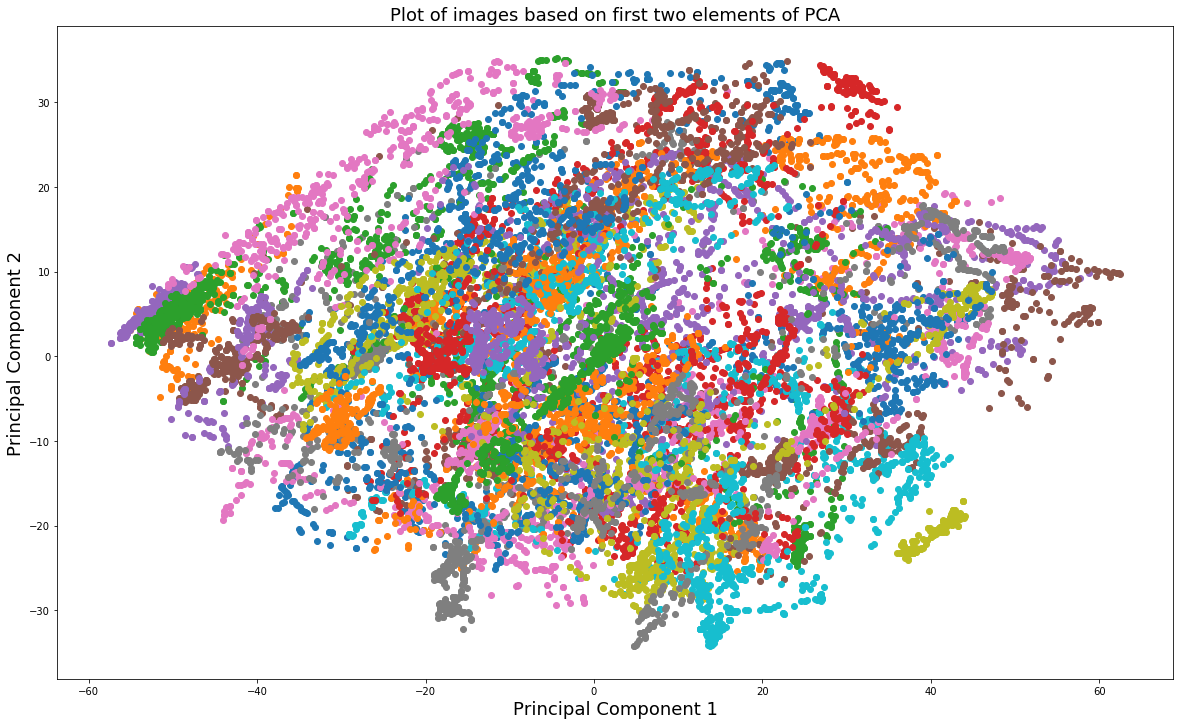

In [15]:
plt.figure(figsize=(20,12))

for fruit in np.unique(y_train_label):
    mask = (y_train_label==fruit)
    pca_fruit = pca_fruit360[mask]
    plt.scatter(pca_fruit[:,0], pca_fruit[:,1], label=fruit)

plt.xlabel('Principal Component 1', size=18);
plt.ylabel('Principal Component 2', size=18);
plt.title('Plot of images based on first two elements of PCA', size=18);

The images have been recorded with a video camera, and each frame has been included in the dataset as a seperate image. The following plots look at the first 15 classes. A PCA is completed, just using the data in the image, and then used to identify any clustering that may be occuring

Clustering would indicate that the may have too little variety in the images to be able to generalise to not previously seen images. 

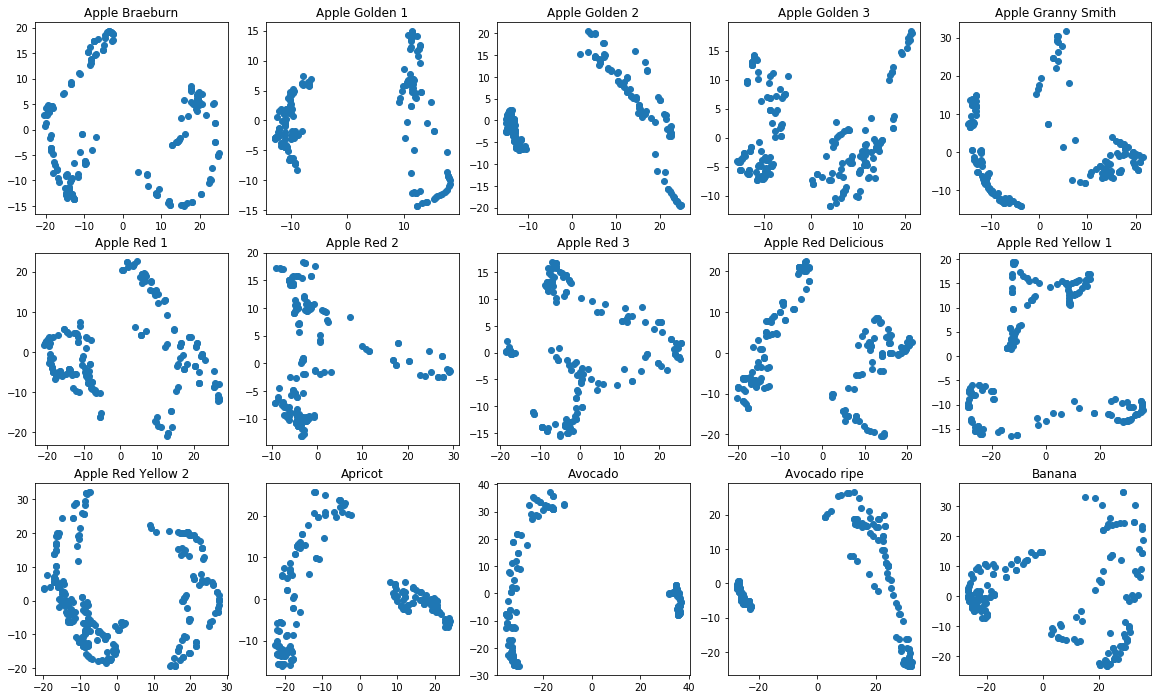

In [16]:
plt.figure(figsize=(20,12))

results = []
for count, fruit in enumerate(np.unique(y_train_label)[:15]):
    mask = (y_train_label==fruit)
    X_fruit = X_train_flat[mask]
    pca = PCA(n_components=2)
    pca_fruit = pca.fit_transform(X_fruit)
    plt.subplot(3,5, count+1)
    plt.scatter(pca_fruit[:,0], pca_fruit[:,1])
    plt.title(fruit)

### Flickr Data

In contrast to the fruit 360 dataset, the Principal Components of the flickr dataset are not restricted to the middle of the image but reach to the edges. Due to the differences in the Principal components, this could indicate that the different structures of the images may make it difficult for a model trained on one set of data to generalise to another.

In [17]:
X_flickr_train_flat = X_flickr_train.reshape(len(X_flickr_train), -1)

pca = PCA(n_components=10)
pca_flickr = pca.fit_transform(X_flickr_train_flat)

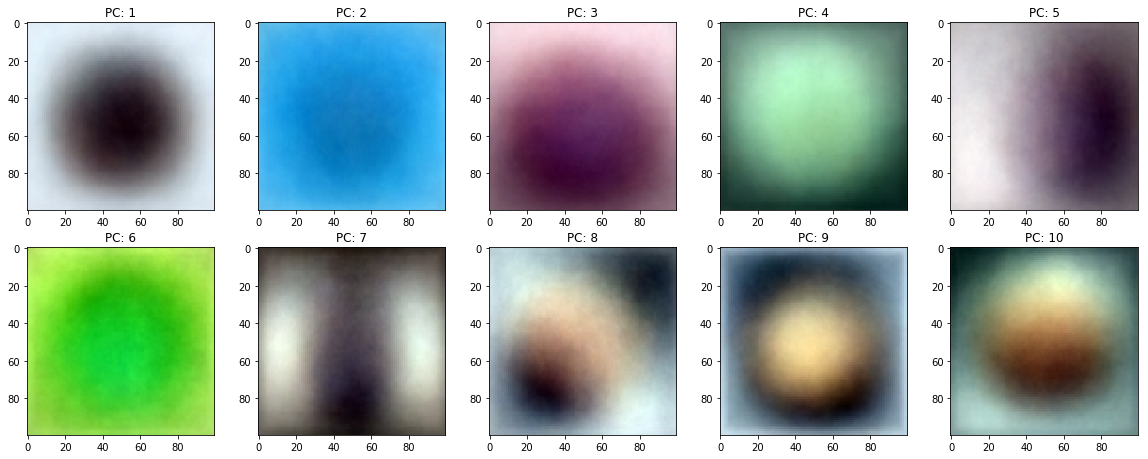

In [18]:
plt.figure(figsize=(20,20))

for count, component in enumerate(pca.components_[:10]):
    plt.subplot(5,5,count+1)
    mincomp = np.min(component)
    maxcomp = np.max(component)
    
    image = (255*(component-mincomp)/(maxcomp-mincomp)).astype(int)
    image = image.reshape((100,100,3))
    
    plt.imshow(image)
    plt.title('PC: '+str(count+1))

The different groups have less clearly distrinctive grouping in the first two Principal Components

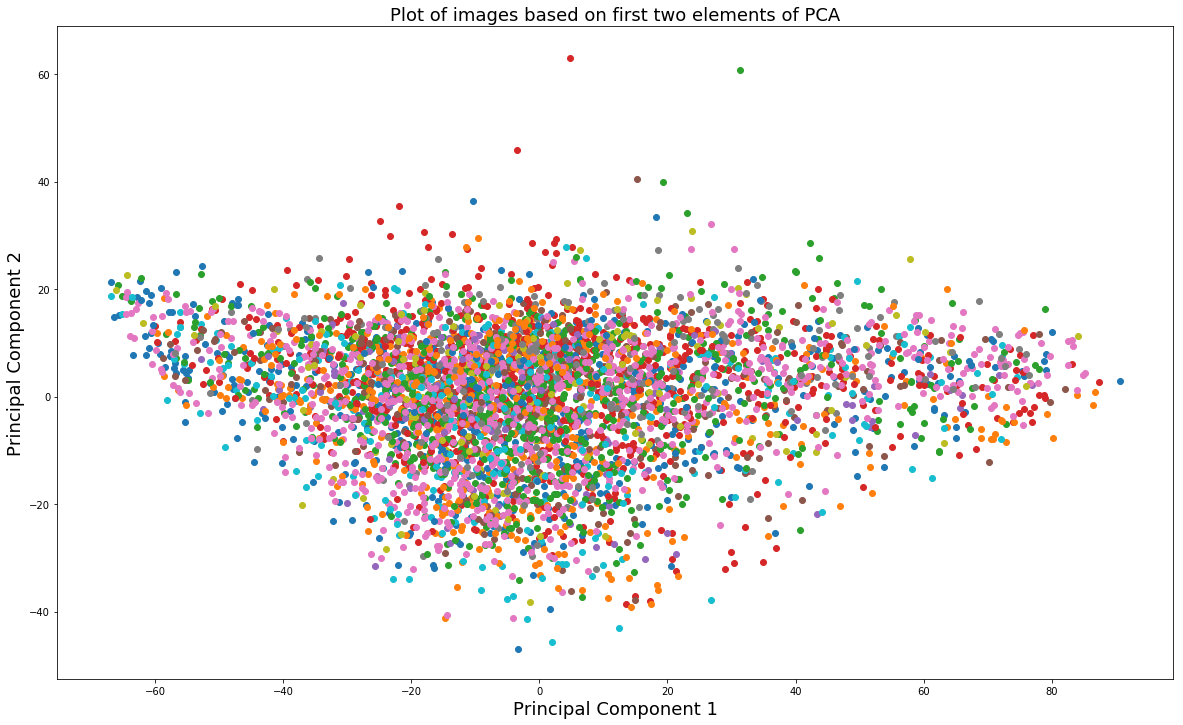

In [19]:
plt.figure(figsize=(20,12))

for fruit in np.unique(y_flickr_train_label):
    mask = (y_flickr_train_label==fruit)
    pca_fruit = pca_flickr[mask]
    plt.scatter(pca_fruit[:,0], pca_fruit[:,1], label=fruit);

plt.xlabel('Principal Component 1', size=18);
plt.ylabel('Principal Component 2', size=18);
plt.title('Plot of images based on first two elements of PCA', size=18);

The images associated with each class show fewer signs of clustering. It may have been expected that certain types of fruit that includes a number of subspecies may form distinctive clusters. However, the first two principal components do not show any evidence of this.

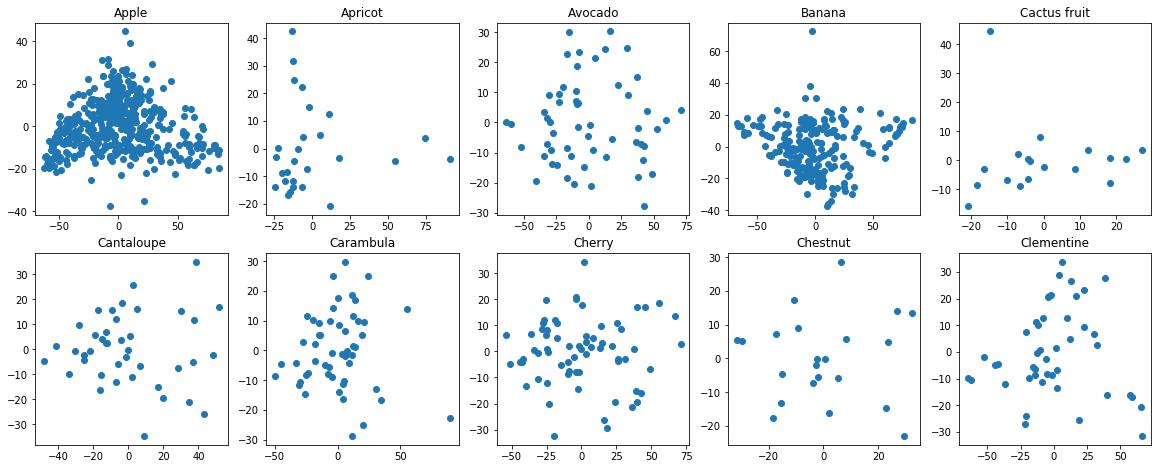

In [20]:
plt.figure(figsize=(20,12))

for count, fruit in enumerate(np.unique(y_flickr_train_label)[:10]):
    mask = (y_flickr_train_label==fruit)
    X_fruit = X_flickr_train_flat[mask]
    pca = PCA(n_components=2)
    pca_fruit = pca.fit_transform(X_fruit)
    plt.subplot(3,5, count+1)
    plt.scatter(pca_fruit[:,0], pca_fruit[:,1])
    plt.title(fruit)

<a id=ModellingSection1></a>
<a id=Benchmark></a>
# Modelling using fruit 360 training data
This section looks at modelling the fruit 360 dataset using a number of different models. Each of the models is assessed against the fruit 360 test data and the flickr data, to see how well the model can be used on more general images of fruit.

In order to assess how well the model will generalise, a new function is created that maps between the label encoder for the fruit 360 data and the flickr labels

In [21]:
def createConversionFunction(label_encoder,label_encoder_flickr):
    '''
    The fruit-360 data comes in 95 different varieties typically sub-species (e.g. Braeburn). The Flicker data comes
    just over 50 varieties typically super species (e.g. Apple). This converts sub-species to super specie.
    
    The input is an array of integers, the output is an array of integers
    
    The flow of this function is:
    '''
    df_supergroup = pd.read_csv('./data/FruitCategories.csv')
    df_supergroup['SubCategoryNumber'] = label_encoder.transform(df_supergroup['SubCategory'])
    df_supergroup['CategoryNumber'] = label_encoder_flickr.transform(df_supergroup['Category'])
    
    def ConversionFunction(input):
        df_input = pd.DataFrame(input, columns=['SubCategoryNumber'])
        df_input = pd.merge(df_input, df_supergroup, how='left', on='SubCategoryNumber')
        output = df_input['CategoryNumber'].values.astype(int) 
        return output
        
    return ConversionFunction    

ConversionFunction = createConversionFunction(label_encoder,label_encoder_flickr)

## Model 1 - Random Forest Benchmark <a id='Model1'></a>

In [22]:
clf = RandomForestClassifier(n_estimators=10)

clf.fit(X_train_flat, y_train)
print('Training accuracy \t: %.1f %%' % (100*clf.score(X_train_flat, y_train)))
X_test_flat = X_test.reshape((len(X_test),-1))
print('Test accuracy \t\t: %.1f %%' % (100*clf.score(X_test_flat, y_test)))

#There exists different labels between the flickr training set and the fruit 360 dataset. The relabelled dataset
predictions = clf.predict(X_flickr_train_flat)
predictions_superclass = ConversionFunction(predictions)
print('Flickr data accuracy \t: %.1f %%'  % (100*accuracy_score(predictions_superclass, y_flickr_train)))


Training accuracy 	: 100.0 %
Test accuracy 		: 92.2 %
Flickr data accuracy 	: 3.8 %


The random forest model has an accuracy of over 90% on the test set. However, the model generalises poorly with similar results as random guess when looking at the flickr data.

In [23]:
del X_train_flat, X_test_flat #create space

## Model 2 - Two layer convolutional neural network <a id='Model2'> </a>
The model below is a convolutional neural network based on the 'LeNet-5' architecture. The model includes 2 convolutional layers before a max pooling layer. Finally, the model introduces a dense layer and a softmax classification layer.

I have also included two dropout layers to reduce overfitting

The model is trained using the Adam optimizer with the loss function being the categorical cross entropy. The accuracy and custom accuracy are recorded

In [24]:
#Define a model:
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=INPUTSHAPE))
model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(3, 3)))
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(264, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(OUTPUTSHAPE, activation='softmax'))

model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', custom_accuracy])  

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 98, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 264)               8651016   
_________________________________________________________________
dropout_1 (Dropout)          (None, 264)               0         
__________

Early stopping is used to determine the number of epochs over which to run the model.

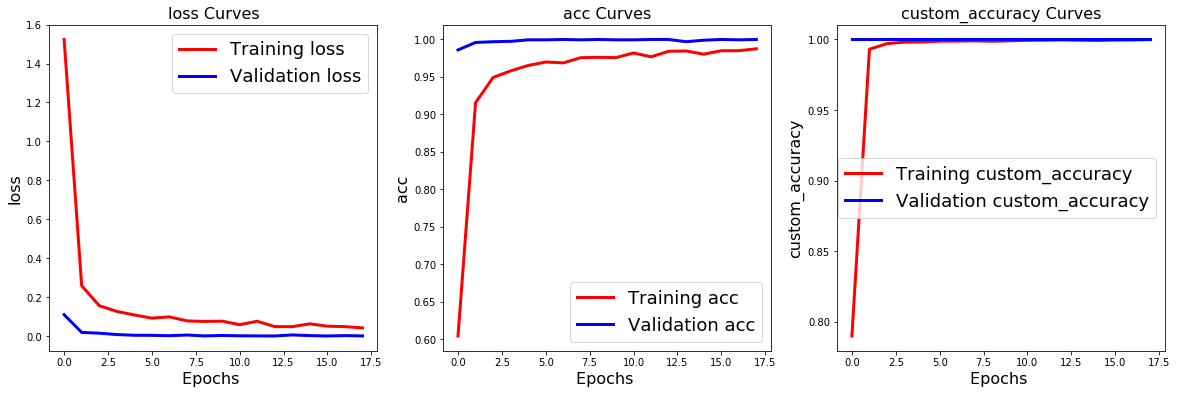

In [25]:
# training model with early stopping
cp_earlystop = EarlyStopping(monitor='val_loss', min_delta=0,
            patience=5, verbose=0, mode='auto')
         
history = model2.fit(X_train, y_train,
                    validation_split=0.1,
                    callbacks = [cp_earlystop],
                    epochs=100, verbose=0)

#plot the training history
plt_history(history)

In [26]:
#evaluate model on test set
print('The accuracy of the model on a test set:')
print('Accuracy \t: %.1f %%' % (100*model2.evaluate(X_test, y_test, verbose=0)[1]))

print('The accuracy of the model on flickr images:')

# Note that the real life images have a different categories. Only the superclass (e.g. Apple) and not 
# the subclass (e.g. Braeburn) has been included
predictions = model2.predict_classes(X_flickr_train)
predictions_superclass = ConversionFunction(predictions)
print('Flickr data accuracy \t: %.1f %%'  % (100*accuracy_score(predictions_superclass, y_flickr_train)))

The accuracy of the model on a test set:
Accuracy 	: 96.0 %
The accuracy of the model on flickr images:
Flickr data accuracy 	: 9.6 %


In [27]:
#save the model
path_weights = './saved_models/model2/weights.h5'
path_model = './saved_models/model2/model.json'

#Save Model
model_json = model2.to_json()
with open(path_model, "w") as json_file:
    json_file.write(model_json)
model2.save_weights(path_weights)

In [28]:
K.clear_session() #reduces the memory footprint
tf.reset_default_graph() #reduces the memory footprint

This model made an improvement on the benchmark random forest classifier
<a id='Model3'></a>

## Model 3 - 4 layer convolutional neural network

In [29]:
class CNN4LayerModel():
    
    def __init__(self, outputshape, 
                 conv1filter = 32, conv1size=3, stride1=2,
                 conv2filter=32, conv2size=3,
                 conv3filter=64, conv3size=3,
                 conv4filter=64, conv4size=3, 
                 denseNodes1=128, dropout1=0.5):
        #Save params for reporting
        self.saved_arguments = locals()
    
        #Create Model
        self.model = Sequential()
        self.model.add(Conv2D(conv1filter,(conv1size,conv1size),padding='same',strides=(stride1,stride1),activation='relu'))
        self.model.add(Conv2D(conv2filter, (conv2size, conv2size),padding ='same',activation='relu'))
        self.model.add(MaxPooling2D(2,2))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(conv3filter, (conv3size, conv3size),padding ='same',activation='relu'))
        self.model.add(Conv2D(conv4filter, (conv4size, conv4size),padding ='same',activation='relu'))
        self.model.add(MaxPooling2D(2,2))
        self.model.add(BatchNormalization())
        self.model.add(Flatten())
        self.model.add(Dense(denseNodes1, activation='relu'))
        self.model.add(Dropout(dropout1))
        self.model.add(BatchNormalization())
        self.model.add(Dense(outputshape, activation='softmax'))
    
    def compile_model(self, optimizer='adam'):
        #compile model
        self.model.compile(optimizer=optimizer,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy', custom_accuracy]) 
        
    def summarise(self):
        self.model.summary()

    def fit(self, X_train, y_train, verbose=0, epochs=100, patience=10):
        #Run model
        cp_earlystop = EarlyStopping(monitor='val_loss', min_delta=0,
            patience=patience, verbose=0, mode='auto')
        
        self.history = self.model.fit(X_train, y_train,
                    validation_split=0.1,
                    callbacks = [cp_earlystop],
                    epochs=epochs, verbose=verbose)
        
    def evaluate(self, X_test, y_test): 
        #Get scores            
        scores = self.model.evaluate(X_test, y_test, verbose=0)
        Accuracyscore = scores[1]
        K_Accuracyscore = scores[2]
                    
        return {**self.saved_arguments, 
                'Training Accuracy' : self.history.history['acc'][-1],
                'Training Top-4 Accuracy': self.history.history['custom_accuracy'][-1],
                'Validation Accuracy':self.history.history['val_acc'][-1],
                'Validation Top-4 Accuracy': self.history.history['val_custom_accuracy'][-1],
                'Test Accuracy': scores[1],
                'Test Top-4 Accuracy': scores[2]}
    
    def plot_results(self):
        plt_history(self.history)
                                    

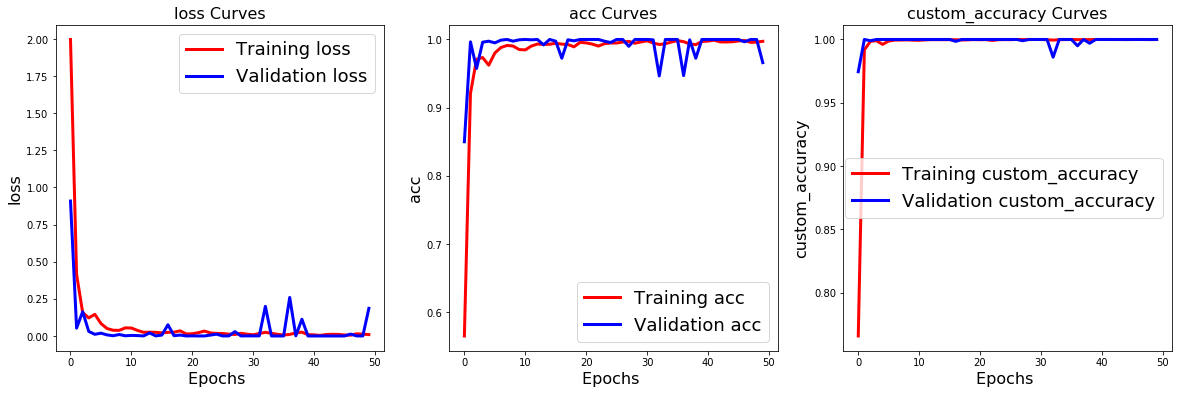

In [30]:
model3 = CNN4LayerModel(OUTPUTSHAPE)
model3.compile_model()
model3.fit(X_train, y_train)
results = model3.evaluate(X_test, y_test)
model3.plot_results()

In [31]:
#evaluate model on test set
print('The accuracy of the model on a test set:')
print('Accuracy \t: %.1f %%' % (100*model3.evaluate(X_test, y_test)['Test Accuracy']))

print('The accuracy of the model on flickr images:')

# Note that the real life images have a different categories. Only the superclass (e.g. Apple vs. Braeburn) has been included
predictions = model3.model.predict_classes(X_flickr_train)
predictions_superclass = ConversionFunction(predictions)
print('Flickr data accuracy \t: %.1f %%'  % (100*accuracy_score(predictions_superclass, y_flickr_train)))

The accuracy of the model on a test set:
Accuracy 	: 93.8 %
The accuracy of the model on flickr images:
Flickr data accuracy 	: 4.9 %


In [32]:
path_weights = './saved_models/model3/weights.h5'
path_model = './saved_models/model3/model.json'

#Save Model
model_json = model3.model.to_json()
with open(path_model, "w") as json_file:
    json_file.write(model_json)
model3.model.save_weights(path_weights)

In [33]:
K.clear_session() #reduces the memory footprint
tf.reset_default_graph() #reduces the memory footprint

## Model 4 - Transfer learning model <a id='Model4'></a>

The following class produces a model that uses a feature vector created by using a trained MobileNET V2. In addition to 

In [34]:
class TransferLearningModel():
    
    def __init__(self, outputshape, dropout1=0.5, dropout2=0.5, denseNodes=264, \
                 featureVectorString='https://tfhub.dev/google/imagenet/mobilenet_v2_100_128/feature_vector/2'):
        #Save params for reporting
        self.saved_arguments = locals()
    
        #Get feature vector
        module = hub.Module(featureVectorString, trainable=False, name='featureVector')
        height, width = hub.get_expected_image_size(module)

        resize_layer = Lambda(lambda x: tf.image.resize_images(x, (height,width)), input_shape = INPUTSHAPE)
        FeatureVector128 = Lambda(module, input_shape = [height,width,3])
        
        #Create Model
        self.model = Sequential()
        self.model.add(resize_layer)
        self.model.add(FeatureVector128)
        self.model.add(Dropout(dropout1))
        self.model.add(Dense(denseNodes, activation='relu'))
        self.model.add(Dropout(dropout2))
        self.model.add(Dense(outputshape, activation='softmax'))
    
    def compile_model(self, optimizer='adam'):
        #compile model
        self.model.compile(optimizer=optimizer,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy', custom_accuracy])  

    def fit(self, X_train, y_train, verbose=0, epochs=100, class_weight=None, patience=5, 
            earlystopping=True, reduce_lr_callback=False, batch_size=32):
        
        #callbacks:
        callbacks=[]
        
        if earlystopping:
            cp_earlystop = EarlyStopping(monitor='val_loss', min_delta=0,
                patience=patience, verbose=0, mode='auto')
            callbacks.append(cp_earlystop)
        
        if reduce_lr_callback:
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=patience//2)
            callbacks.append(reduce_lr)
        
        #Fit model
        self.history = self.model.fit(X_train, y_train,
                    validation_split=0.1,
                    batch_size=batch_size,
                    callbacks = callbacks,
                    class_weight=class_weight,
                    epochs=epochs, verbose=verbose)
        
    def evaluate(self, X_test, y_test):
        #Get scores            
        scores = self.model.evaluate(X_test, y_test, verbose=0)
        Accuracyscore = scores[1]
        K_Accuracyscore = scores[2]
                    
        return {**self.saved_arguments, 
                'Training Accuracy' : self.history.history['acc'][-1],
                'Training Top-4 Accuracy': self.history.history['custom_accuracy'][-1],
                'Validation Accuracy':self.history.history['val_acc'][-1],
                'Validation Top-4 Accuracy': self.history.history['val_custom_accuracy'][-1],
                'Test Accuracy': scores[1],
                'Test Top-4 Accuracy': scores[2]}
    
    def plot_results(self):
        plt_history(self.history)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0330 18:58:41.070843 17164 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


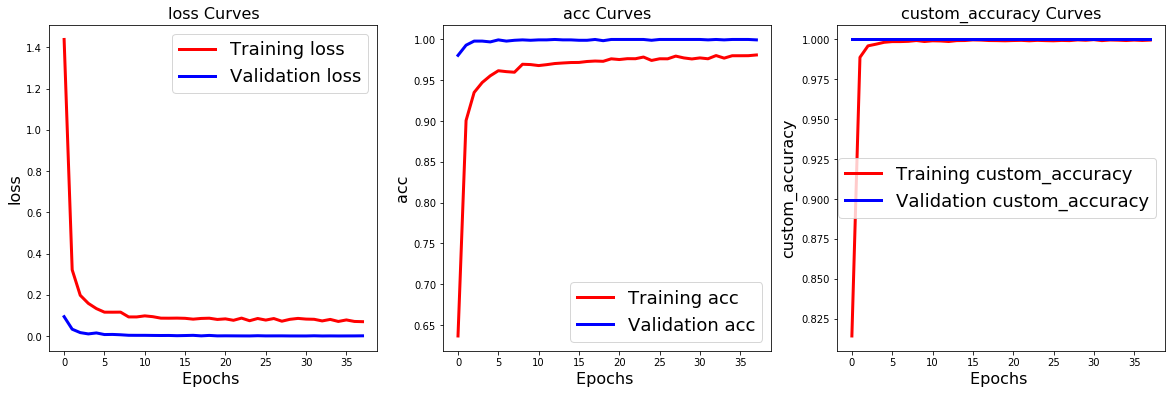

In [35]:
model4 = TransferLearningModel(OUTPUTSHAPE)
model4.compile_model()
results = model4.fit(X_train, y_train)
model4.evaluate(X_test, y_test)
model4.plot_results()

In [36]:
#evaluate model on test set
print('The accuracy of the model on a test set:')
print('Accuracy \t: %.1f %%' % (100*model4.evaluate(X_test, y_test)['Test Accuracy']))

print('The accuracy of the model on flickr images:')

# Note that the real life images have a different categories. Only the superclass (e.g. Apple vs. Braeburn) has been included
predictions = model4.model.predict_classes(X_flickr_train)
predictions_superclass = ConversionFunction(predictions)
print('Flickr data accuracy \t: %.1f %%'  % (100*accuracy_score(predictions_superclass, y_flickr_train)))

The accuracy of the model on a test set:
Accuracy 	: 98.3 %
The accuracy of the model on flickr images:
Flickr data accuracy 	: 23.1 %


In [37]:
path_weights = './saved_models/model4/weights.h5'
path_model = './saved_models/model4/model.json'

#Note that the model does not save using the path save_model method. 
model4.model.save_weights(path_weights)

In [38]:
#Done with fruit 360 dataset - free up some memory
del  X_train,y_train, X_test, y_test
K.clear_session() #reduces the memory footprint
tf.reset_default_graph() #reduces the memory footprint


## Commentary <a id=Comments1></a>

The Fruit 360 dataset provides a large number of images that enable the models all to perform well at identifying the test images. The results on the testing dataset are all above 90%, with CNNs improving the results between 95%-98%.

The model provides poor results to generalising to the images from flickr. Clearly there are a number of structual differences between the fruit 360 dataset and the flickr dataset including:
* scale
* only singular pieces of fruit in the image
* fruit cropped, centred and rescaled to fill the image
* Pre-processed images with white background
* The variety of data

It may be a future project to determine whether the ability of the these training images to generalise to real life images can be improved. Some ideas for future projects can be:
* Using a "Region Proposal Network' (RPN) to produce a range of candidate areas of interest from an image. Each of these areas can be treated like an image, and analysed to see whether it contains any fruit
* Using data augmentation techniques, like skewing to increase the variety of the images. This may help to identify more general features that are beneficial to detecting types of fruit.

Noticably, model 4 which was built using a feature vector from a trained MobileNET V2 generalised significantly better than the other two models.

# Modelling using flickr training data<a id='ModellingSection2'></a> 
## Model 5 - Random Forest<a id="Model5"></a>

The following produces a benchmark accuracy for the flickr data using Random Forest. Due to the small training data size, 5 fold cross validation is being performed on the sample, with the cross validation accuracy being the mean of the 5 results. Note that the results have not been been based on any hyper-parameter tuning. It will be clear to see in the next section that the results using CNNs are superior, and no further work on Random Forest is warranted.

In [39]:
model5 = RandomForestClassifier(n_estimators=10)
results = cross_val_score(model5, X_flickr_train_flat, y_flickr_train, cv = 5)
print('Cross validation accuracy \t\t: %.1f  %%'  % (100*np.mean(results)))

Cross validation accuracy 		: 22.5  %


The score is marginally higher than the score for model 4, which was trained on the fruit 360 dataset. 

In [40]:
# No longer required, delete to reduce memory footprint
del X_flickr_train_flat

## Model 6 - CNN (4 Convolutional Layers)

This following section applies the CNN that was original defined under Model 3 to the flickr training set.

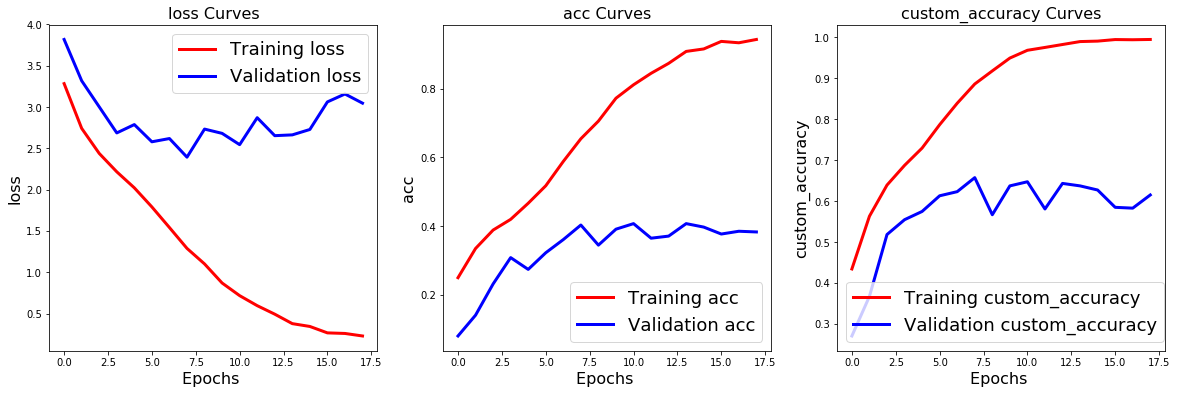

In [41]:
model6 = CNN4LayerModel(OUTPUTSHAPEFLICKR)
model6.compile_model()
model6.fit(X_flickr_train, y_flickr_train)
results = model6.evaluate(X_flickr_test, y_flickr_test)

model6.plot_results()

In [42]:
#evaluate model on test set
print('The accuracy of the model on a test set:')
print('Accuracy \t: %.1f %%' % (100*results['Test Accuracy']))
print('Top-4 Accuracy \t: %.1f %%' % (100*results['Test Top-4 Accuracy']))

The accuracy of the model on a test set:
Accuracy 	: 41.3 %
Top-4 Accuracy 	: 62.3 %


In [43]:
model6.summarise()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25, 25, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
__________

## Commentary <a id='Comments2'></a>

The model is an improvement over the random forest with an improvement to the accuracy to just under 40%. The loss score continues to improve for the training data upto epoch 20, whilst the validation score is volatile after epoch 5, leading to overfitting.

If time permits, improvements to this model may be possible by using smaller learning rates, higher regularization (through dropouts and L1/L2 alpha regularization of params or using image augmentation techniques. The model has over 1,000,000 parameters that require learning and the dataset is small. It is not clear to me how much improvement is possible with this little data. Due to the improvement in results for the transfer learning model below, no further analysis has been completed using this model.

In [44]:
path_weights = './saved_models/model6/weights.h5'
path_model = './saved_models/model6/model.json'

#Save Model
model_json = model6.model.to_json()
with open(path_model, "w") as json_file:
    json_file.write(model_json)
model6.model.save_weights(path_weights)

In [45]:
K.clear_session() #reduces the memory footprint
tf.reset_default_graph() #reduces the memory footprint

## Model 7 - Transfer learning using Mobilenet V2 <a id="Model7"></a>

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0330 19:21:17.328936 17164 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


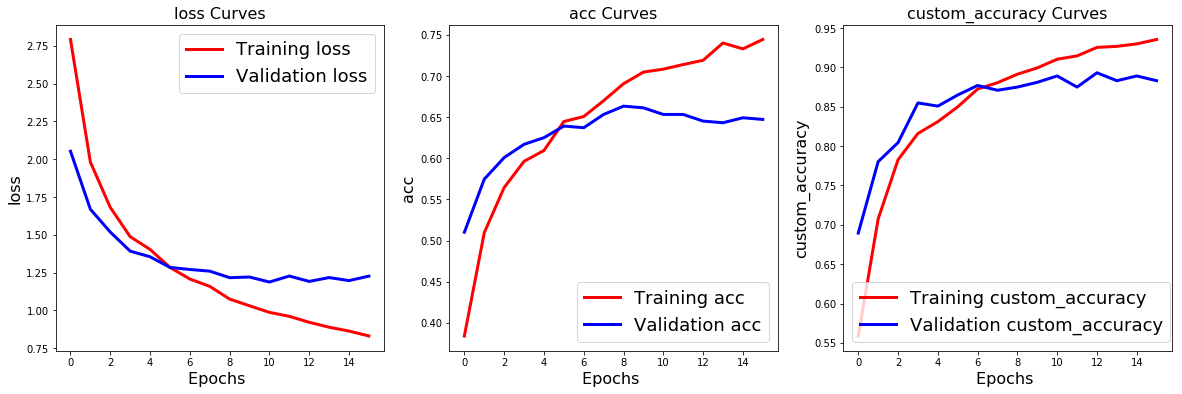

In [46]:
model7 = TransferLearningModel(OUTPUTSHAPEFLICKR)
model7.compile_model()
model7.fit(X_flickr_train, y_flickr_train),
results = model7.evaluate(X_flickr_test, y_flickr_test)
model7.plot_results()

In [47]:
#evaluate model on test set
print('The accuracy of the model on a test set:')
print('Accuracy \t: %.1f %%' % (100*results['Test Accuracy']))
print('Top-4 Accuracy \t: %.1f %%' % (100*results['Test Top-4 Accuracy']))

The accuracy of the model on a test set:
Accuracy 	: 67.0 %
Top-4 Accuracy 	: 85.1 %


In [48]:
path_weights = './saved_models/model7/weights.h5'
path_model = './saved_models/model7/model.json'

#Note that the model does not save using the path save_model method. 
model7.model.save_weights(path_weights)

The model produces accuracy of around 70%, and a top 4 accuracy of around 90%. This model is more successful than mdel 5 and model 6 reviewed. The following code looks at the testing precision and recall for each of the fruits in general. The size of the bubbles in the chart indicate the size ('support') of that group in the data.

The chart indicates that whilst there are many classes with good precision and recall, there is a significant difference between the best and worst categories. Indeed, there are some types of fruit that have zero precision and recall (on the test set). In general, it is the smaller groups that have worse recall and accuracy. Looking at class imbalance in more detail may resolve some of these isssues.

c:\users\johnr\anaconda3\envs\python35gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


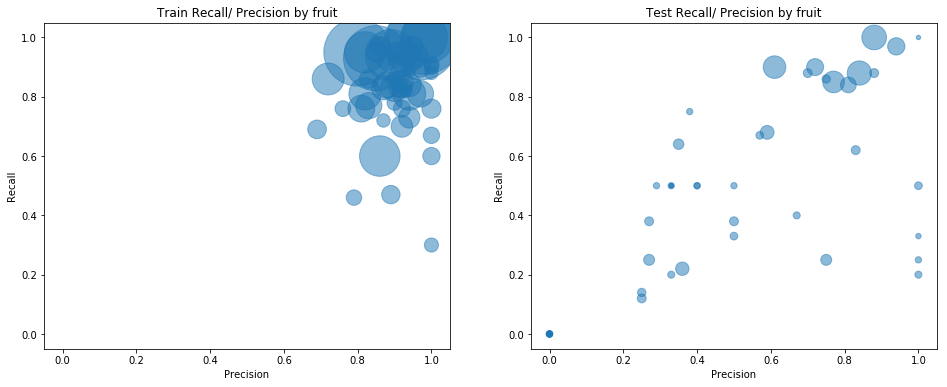

In [49]:
plt.figure(figsize=(16,6))
counter=1
for title, x, y in [('Train', X_flickr_train, y_flickr_train),('Test', X_flickr_test, y_flickr_test)]:
    plt.subplot(1,2,counter)
    y_predict = model7.model.predict_classes(x)
    labels_predict = label_encoder_flickr.inverse_transform(y_predict)
    labels_true = label_encoder_flickr.inverse_transform(y)

    cr = classification_report_as_df(labels_true, labels_predict)

    plt.scatter(cr['Precision'], cr['Recall'], s=cr['Support']*10, alpha=0.5 );
    plt.title(title+' Recall/ Precision by fruit');
    plt.ylabel('Recall');
    plt.xlabel('Precision');
    counter +=1
    plt.ylim((-0.05,1.05))
    plt.xlim((-0.05,1.05))
    

The above chart indicates that certain (mostly smaller) classes have poor recall and precision scores for the test dataset - some of which are nil. The 'macro f1-score' has been calculated. The macro f1 score is the average f1 score for each group (calculated in the usual manner). It has an equal weighting to both small groups and large groups, unlike accuracy. The F1 score is around 50%. Note that the test set is quite small, and can lead to a high uncertainty to the true macro f1 score of the model.

In [50]:
round(100*f1_score(labels_true, labels_predict,average='macro',),1)

c:\users\johnr\anaconda3\envs\python35gpu\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


39.0

## Model 8 - Transfer learning using class weightings

The following model makes an allowance for the class imbalances by modifying the loss function to include a higher weighting for the less common classes. The hope is to improve the macro f1 score.

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0330 19:23:37.870006 17164 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


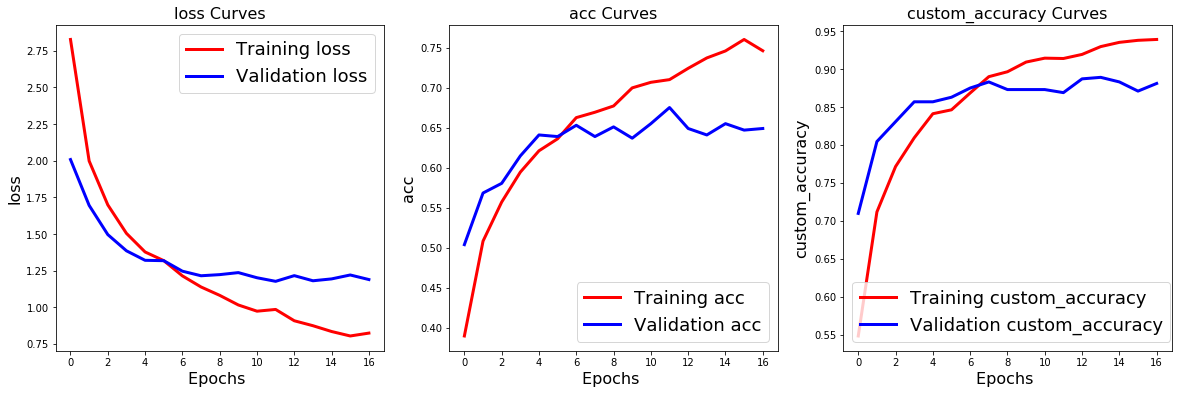

In [51]:
model8 = TransferLearningModel(OUTPUTSHAPEFLICKR)
model8.compile_model()
model8.fit(X_flickr_train, y_flickr_train, class_weight=class_weights_flickr)
results = model8.evaluate(X_flickr_test, y_flickr_test)
model8.plot_results()

In [52]:
#evaluate model on test set
print('The accuracy of the model on a test set:')
print('Accuracy \t: %.1f %%' % (100*results['Test Accuracy']))
print('Top-4 Accuracy \t: %.1f %%' % (100*results['Test Top-4 Accuracy']))

The accuracy of the model on a test set:
Accuracy 	: 67.4 %
Top-4 Accuracy 	: 86.6 %


In [53]:
path_weights = './saved_models/model8/weights.h5'
path_model = './saved_models/model8/model.json'

#Note that the model does not save using the path save_model method. 
model8.model.save_weights(path_weights)

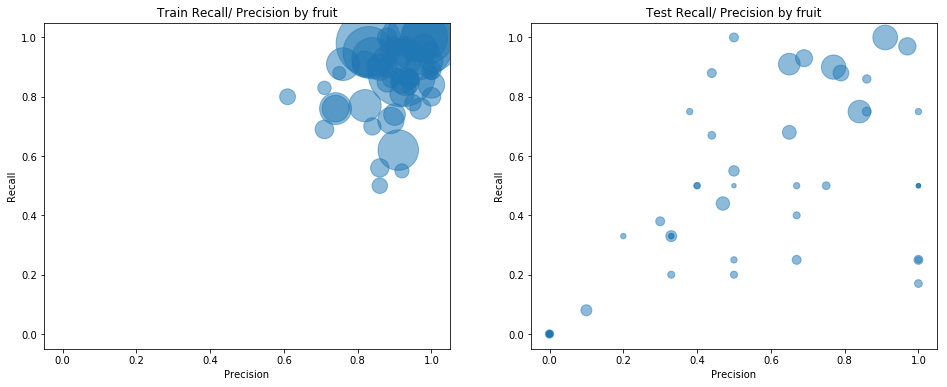

In [54]:
plt.figure(figsize=(16,6))
counter=1
for title, x, y in [('Train', X_flickr_train, y_flickr_train),('Test', X_flickr_test, y_flickr_test)]:
    plt.subplot(1,2,counter)
    y_predict = model8.model.predict_classes(x)
    labels_predict = label_encoder_flickr.inverse_transform(y_predict)
    labels_true = label_encoder_flickr.inverse_transform(y)

    cr = classification_report_as_df(labels_true, labels_predict)

    plt.scatter(cr['Precision'], cr['Recall'], s=cr['Support']*10, alpha=0.5 );
    plt.title(title+' Recall/ Precision by fruit');
    plt.ylabel('Recall');
    plt.xlabel('Precision');
    counter +=1
    plt.ylim((-0.05,1.05))
    plt.xlim((-0.05,1.05))

In [55]:
round(100*f1_score(labels_true, labels_predict,average='macro',),1)

41.2

Model 8 has improved the macro f1 score compared to Model 7. The f1 score is still relatively low and there are a few classes in the test sample with an f1 score of nil.

Further work could be completed to increase the f1 scores globally. One possible route for another purpose would be to over sample from the smaller groups. Given that some of these groups have fewer than 20 images, it is not clear how much improvement can be expected using this type of approach.

The following sections looks only at the flickr fruit subset that includes only the fruits with more than 120 images

In [56]:
K.clear_session() #reduces the memory footprint
tf.reset_default_graph() #reduces the memory footprint

# Training a model on a reduced fruit subset <a id='ModellingSection3'></a>

This sections looks at only classifying fruit from the 11 largest classes. Including only the largest groups reduces the class imbalance problem that was prevalent in the prior section.

## Model 9 - Random Forest <a id='Model9'></a>

In [57]:
X_flickr_subset_train_flat = X_flickr_subset_train.reshape(len(X_flickr_subset_train), -1)

model9 = RandomForestClassifier(n_estimators=10)
results = cross_val_score(model9, X_flickr_subset_train_flat, y_flickr_subset_train, cv = 5)
print('Cross validation accuracy \t\t: %.1f  %%'  % (100*np.mean(results)))


Cross validation accuracy 		: 37.7  %


The accuracy of the model is improved compared to the Random Forest model used for the full flickr dataset, as should be expected.

### Model 10 - CNN (4 convolutional layers) 

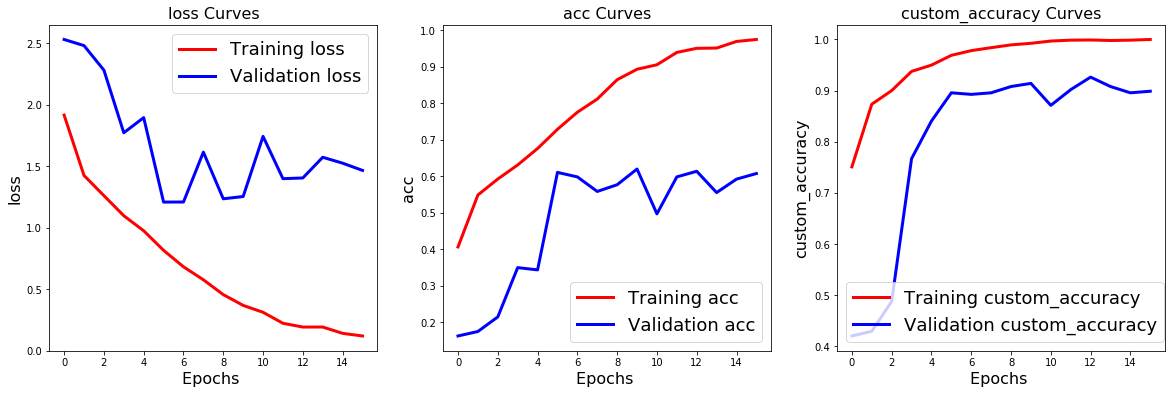

In [58]:
model10 = CNN4LayerModel(OUTPUTSHAPEFLICKRSUBSET)
model10.compile_model()
model10.fit(X_flickr_subset_train, y_flickr_subset_train)
results = model10.evaluate(X_flickr_subset_test, y_flickr_subset_test)
model10.plot_results()

In [59]:
#evaluate model on test set
print('The accuracy of the model on a test set:')
print('Accuracy \t: %.1f %%' % (100*results['Test Accuracy']))
print('Top-4 Accuracy \t: %.1f %%' % (100*results['Test Top-4 Accuracy']))

The accuracy of the model on a test set:
Accuracy 	: 63.0 %
Top-4 Accuracy 	: 89.2 %


In [60]:
path_weights = './saved_models/model10/weights.h5'
path_model = './saved_models/model10/model.json'

#Save Model
model_json = model10.model.to_json()
with open(path_model, "w") as json_file:
    json_file.write(model_json)
model10.model.save_weights(path_weights)

In [61]:
K.clear_session() #reduces the memory footprint
tf.reset_default_graph() #reduces the memory footprint

Model 10 has significantly improved the results over the Random Forest model. Consistent with the modelling with the full flickr dataset, the models accuracy of the validation dataset continues to improve until around the 5th epoch, before overfitting starts occuring. This can be seen by the steadily worsening validation accuracy after this point. 

## Model 11 - Transfer learning using the Mobilenet V2 model <a id='Model11'></a>

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0330 19:27:20.731068 17164 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


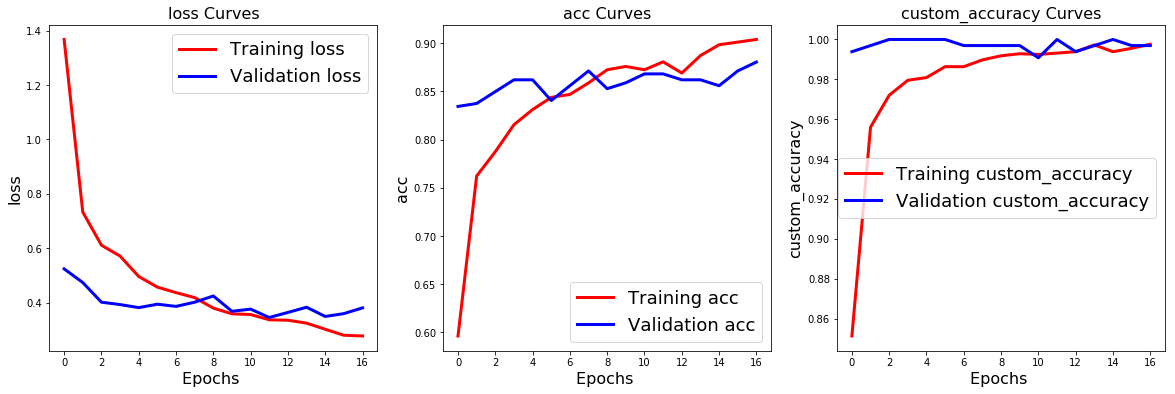

In [62]:
model11 = TransferLearningModel(OUTPUTSHAPEFLICKRSUBSET)
model11.compile_model()
model11.fit(X_flickr_subset_train, y_flickr_subset_train)
results = model11.evaluate(X_flickr_subset_test, y_flickr_subset_test)
model11.plot_results()

In [63]:
#evaluate model on test set
print('The accuracy of the model on a test set:')
print('Accuracy \t: %.1f %%' % (100*results['Test Accuracy']))
print('Top-4 Accuracy \t: %.1f %%' % (100*results['Test Top-4 Accuracy']))

The accuracy of the model on a test set:
Accuracy 	: 87.8 %
Top-4 Accuracy 	: 99.7 %


## Commentary <a id='Comments3'></a>

Again, the model using a feature vector from the MobileNET v2 pre-trained model has led to improvements in the results of the modelling. The Accuracy has increased to nearly 90%, whilst the top-4 accuracy is around the 99% mark.

The learning progress chart above indicate that there appears to be continued improvement in the accuracy and loss metrics even near the end of the training. There may be some benefits to reducing the learning rate and increasing the patience level of the early stopping parameter as part of the opimization parocess.

In [64]:
path_weights = './saved_models/model11/weights.h5'
model11.model.save_weights(path_weights)

In [65]:
K.clear_session() #reduces the memory footprint
tf.reset_default_graph() #reduces the memory footprint

# Tuning <a id='Hyperparam'></a>

## Optimizer hyperparameter tuning <a id='optimizer'></a>

The optimizer currently being used is the Adam optimizer from the keras library with the standard options applied. In addition, the patience for early stopping is 5 epochs.

There are a number of options available for tuning the optimizer, the two that I will look at are the patience and the impact of introducing a 'callback function' to the opimization. In this case, the optimizer will reduce the learning rate of the optimizer if the loss is not improving. A higher starting learning rate is being used to increase the speed to reaching a plateau. 

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0330 19:28:51.543741 17164 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Patience : 5 Test Accuracy : 87.3 


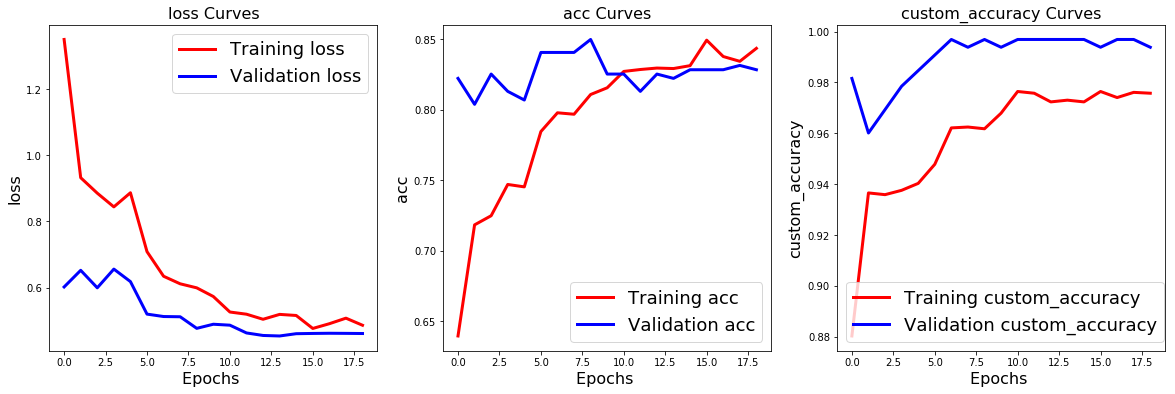

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0330 19:30:31.183945 17164 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Patience : 10 Test Accuracy : 87.0 


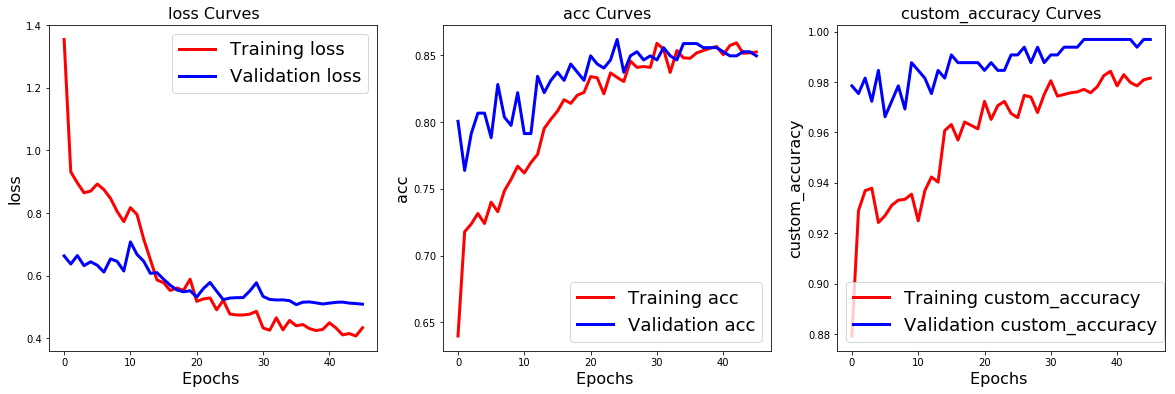

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0330 19:34:40.702346 17164 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Patience : 15 Test Accuracy : 88.1 


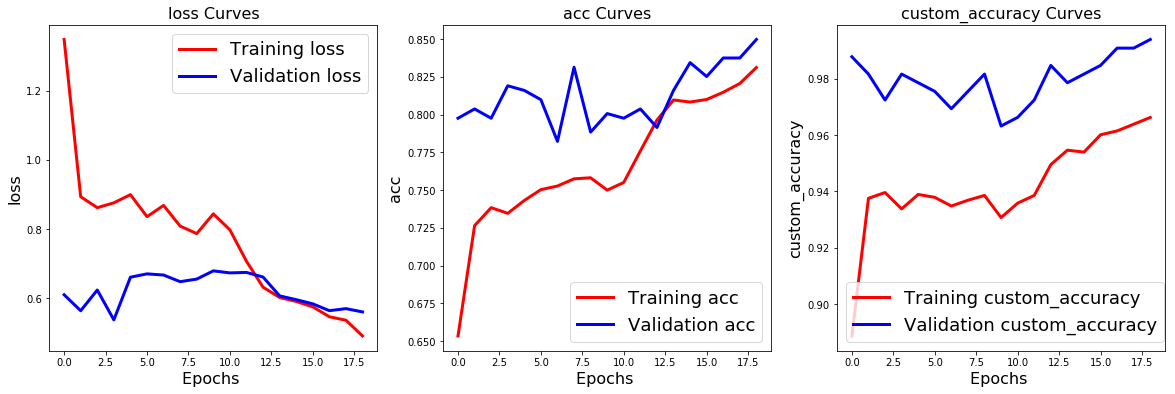

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0330 19:36:23.565414 17164 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Patience : 20 Test Accuracy : 87.3 


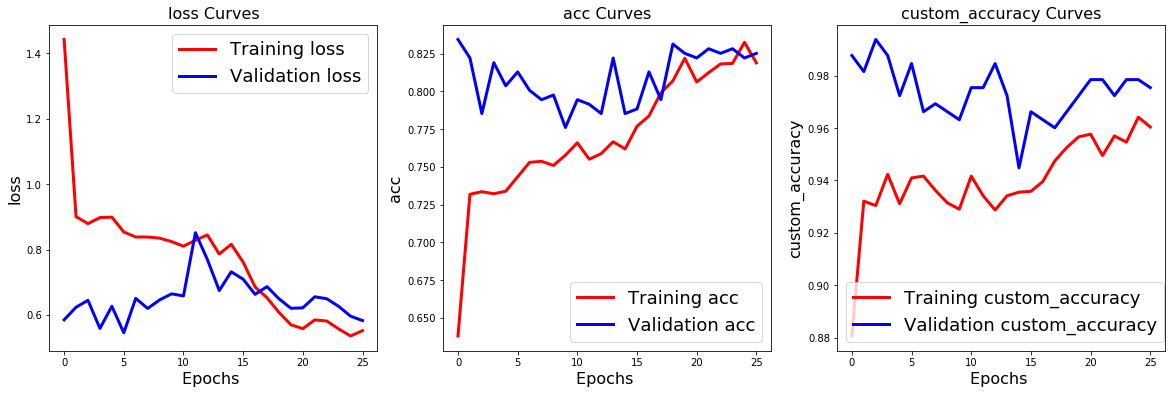

In [66]:
results = []
for counter, patience in enumerate([5,10,15]):
    optimiser = Adam(lr=0.01)
    model = TransferLearningModel(OUTPUTSHAPEFLICKRSUBSET)
    model.compile_model(optimiser)
    model.fit(X_flickr_subset_train, y_flickr_subset_train, epochs=1000, patience=patience, reduce_lr_callback =True, verbose=0)
    model_results = model.evaluate(X_flickr_subset_test, y_flickr_subset_test)
    print('Patience : {}' .format(patience), 'Test Accuracy : {} ' .format(100*round(model_results['Test Accuracy'],3)))
    model.plot_results()
    plt.show()
    results.append({'Patience':patience,
                     'Test Accuracy':model_results['Test Accuracy']})
    K.clear_session() #reduces the memory footprint
    tf.reset_default_graph() #reduces the memory footprint
    
results = pd.DataFrame(results)

In [67]:
results.sort_values('Test Accuracy', ascending=False)

Patience  Test Accuracy
2        15       0.881215
0         5       0.872928
3        20       0.872928
1        10       0.870166

The alternative optimizing approaches provide slightly improved results compared to model 11. However, as is seen in the next section, significant uncertainty exists to what the true underlying accuracy rates are. It is difficult to measure these due to the small amount of data available.

Further analysis could be completed by using a K fold cross validation to more accurately assess the accuracy of the model, and to determine whether the alternative hyper-parameters are improving the model. 

### Hyper-parameter tuning
There are a wide range of tuning possibilities for the model being used.
* Feature vector
* Dropout sizes
* Nodes in dense layer
* Number of layers
* Activation functions

For the purposes of this section, only the dropout size is being reviewed. The model is being run numerous times. The model has three sources of randomness - the initialization weights, the stochastic gradient descent and the set chosen for the validation set. Taking an average

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0330 19:38:49.109513 17164 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Nodes : 32 Test Accuracy : 87.8 


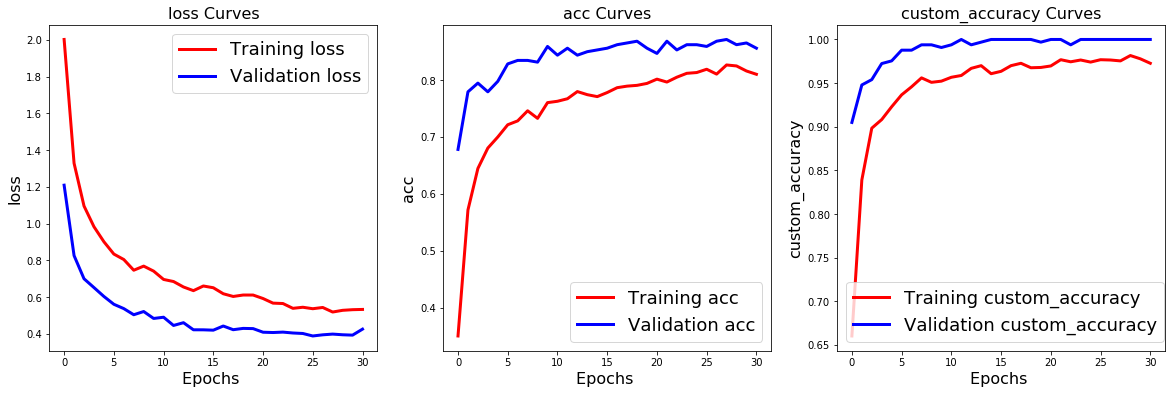

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0330 19:41:30.582436 17164 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Nodes : 32 Test Accuracy : 85.6 


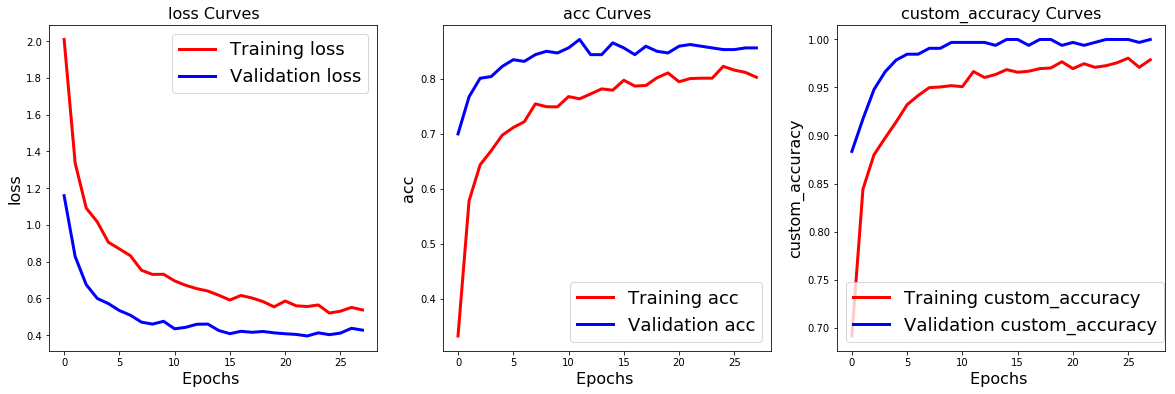

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0330 19:43:57.278489 17164 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Nodes : 32 Test Accuracy : 89.5 


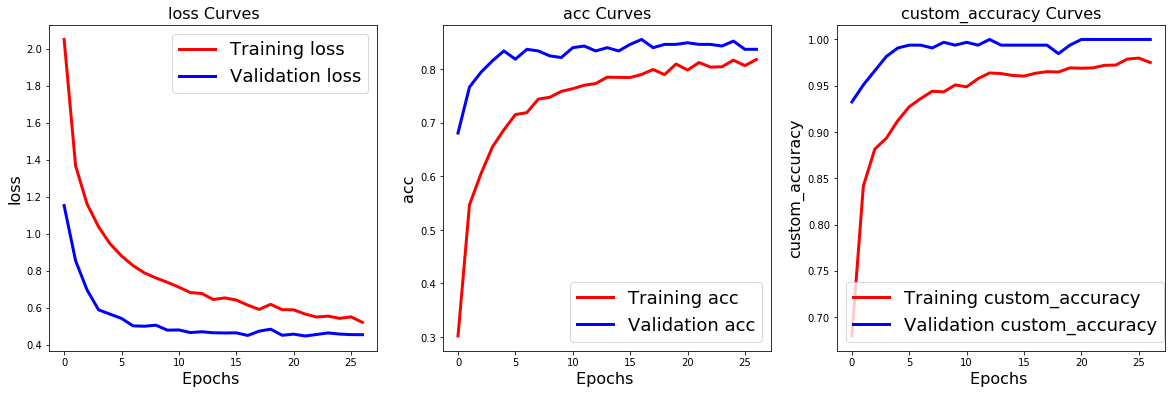

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0330 19:46:20.163373 17164 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Nodes : 64 Test Accuracy : 86.2 


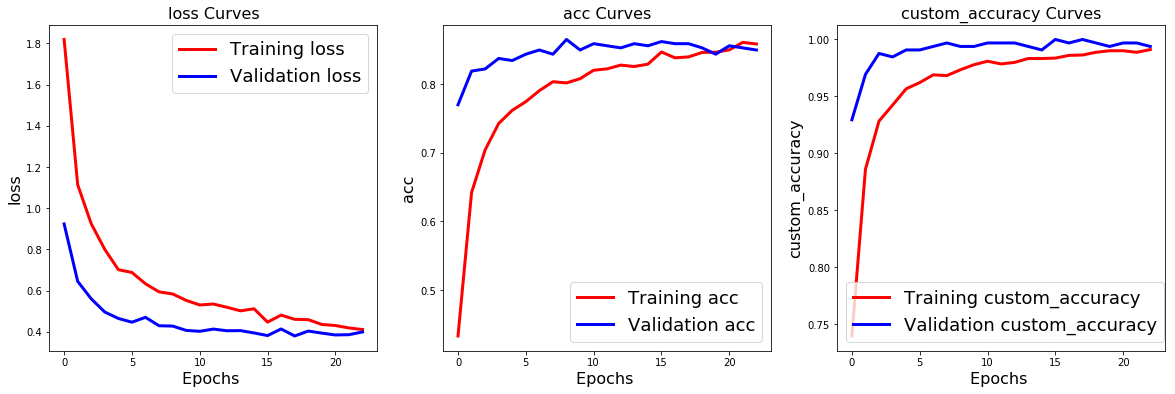

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0330 19:48:27.852152 17164 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Nodes : 64 Test Accuracy : 86.5 


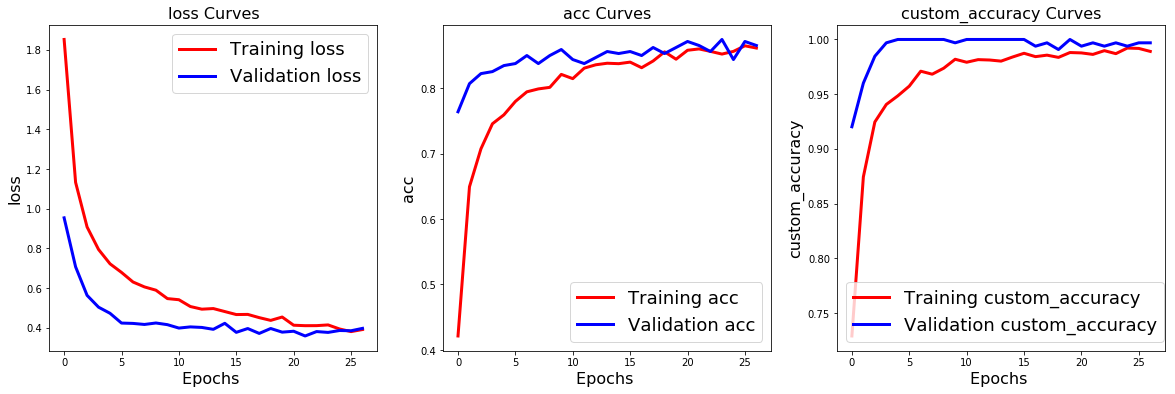

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0330 19:50:53.351414 17164 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Nodes : 64 Test Accuracy : 87.8 


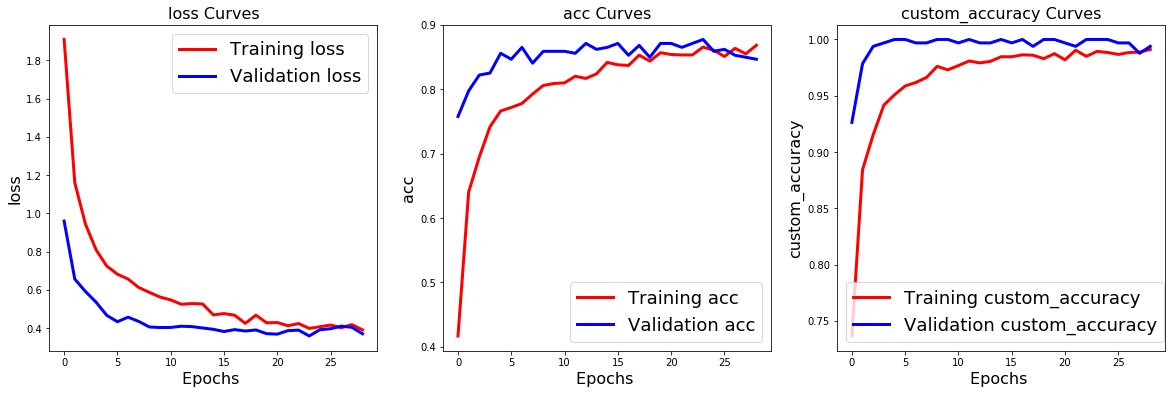

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0330 19:53:24.746245 17164 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Nodes : 128 Test Accuracy : 88.4 


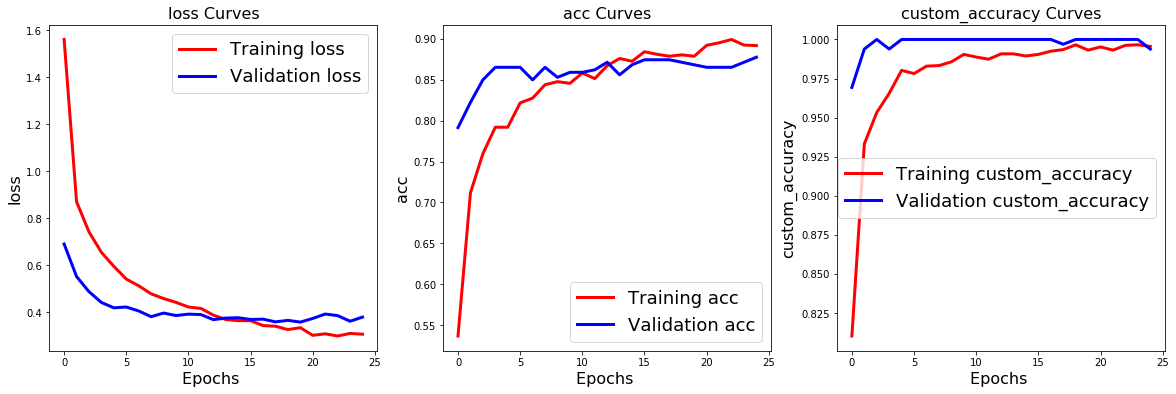

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0330 19:55:43.863510 17164 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Nodes : 128 Test Accuracy : 86.2 


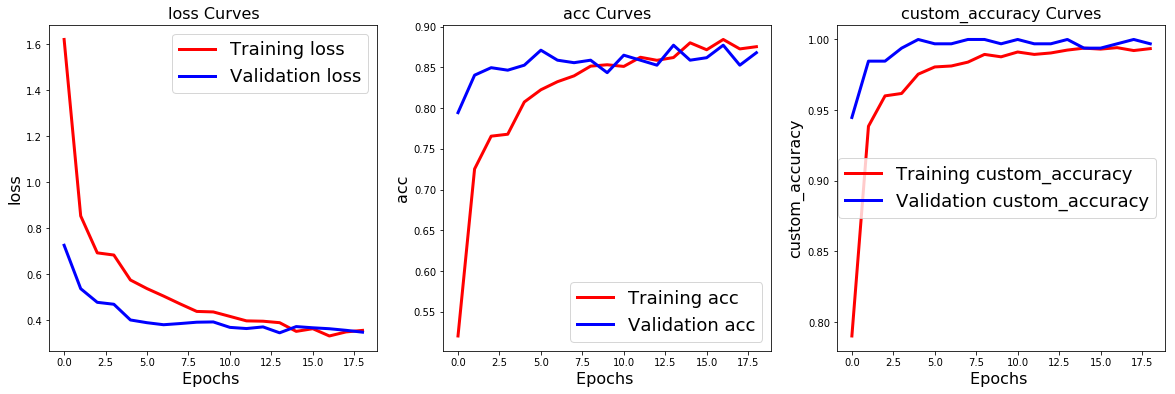

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0330 19:57:32.399888 17164 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Nodes : 128 Test Accuracy : 87.3 


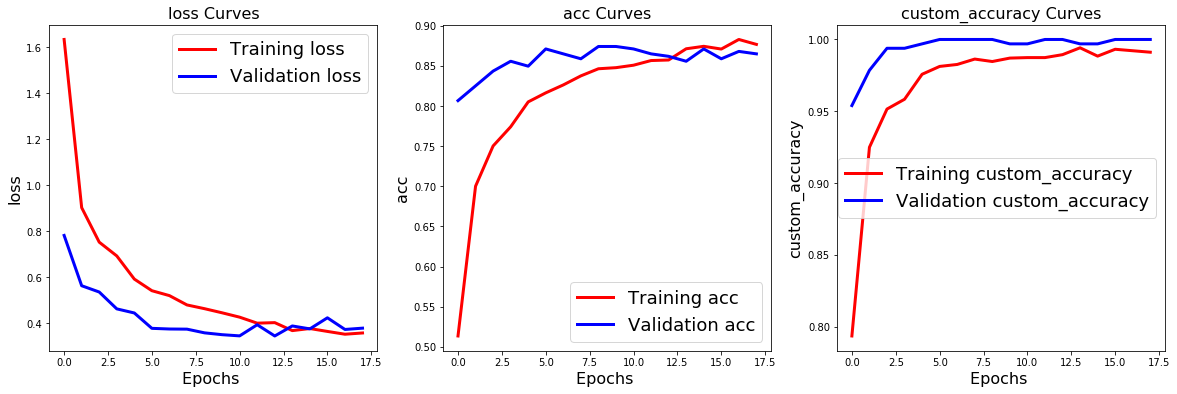

In [68]:
#Number of repeats for averaging:
repeats=3
results=[]
for denseNodes in [32, 64, 128]:
    for repeat in range(repeats):
        model = TransferLearningModel(OUTPUTSHAPEFLICKRSUBSET, denseNodes=denseNodes)
        model.compile_model()
        model.fit(X_flickr_subset_train, y_flickr_subset_train)
        model_results=model.evaluate(X_flickr_subset_test, y_flickr_subset_test)
        print('Nodes : {}' .format(denseNodes), 'Test Accuracy : {} ' .format(100*round(model_results['Test Accuracy'],3)))
        model.plot_results()
        plt.show()

        results.append(model_results)
        K.clear_session() #reduces the memory footprint
        tf.reset_default_graph() #reduces the memory footprint

results = pd.DataFrame(results)

In [69]:
del results['self']
metrics = ['Training Accuracy', 'Validation Accuracy', 'Test Accuracy',
           'Training Top-4 Accuracy', 'Validation Top-4 Accuracy', 'Test Top-4 Accuracy']

#group by hyper-params across all runs
non_metrics = [x for x in results.columns if x not in metrics]
grouped_results = results.groupby(by=non_metrics).mean()
grouped_results.sort_values('Test Accuracy', ascending=False)

Test Accuracy  \
denseNodes dropout1 dropout2 featureVectorString                                outputshape                  
32         0.5      0.5      https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                0.876611   
128        0.5      0.5      https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                0.872928   
64         0.5      0.5      https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                0.868324   

                                                                                             Test Top-4 Accuracy  \
denseNodes dropout1 dropout2 featureVectorString                                outputshape                        
32         0.5      0.5      https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                      0.987109   
128        0.5      0.5      https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                      0.993554   
64         0.5      0.5      https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                      0.996317   

                                                                                             Training Accuracy  \
denseNodes dropout1 dropout2 featureVectorString                                outputshape                      
32         0.5      0.5      https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                    0.810304   
128        0.5      0.5      https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                    0.881269   
64         0.5      0.5      https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                    0.862618   

                                                                                             Training Top-4 Accuracy  \
denseNodes dropout1 dropout2 featureVectorString                                outputshape                            
32         0.5      0.5      https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                          0.975549   
128        0.5      0.5      https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                          0.993404   
64         0.5      0.5      https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                          0.990447   

                                                                                             Validation Accuracy  \
denseNodes dropout1 dropout2 featureVectorString                                outputshape                        
32         0.5      0.5      https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                      0.849693   
128        0.5      0.5      https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                      0.870143   
64         0.5      0.5      https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                      0.853783   

                                                                                             Validation Top-4 Accuracy  
denseNodes dropout1 dropout2 featureVectorString                                outputshape                             
32         0.5      0.5      https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                            1.000000  
128        0.5      0.5      https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                            0.996933  
64         0.5      0.5      https://tfhub.dev/google/imagenet/mobilenet_v2_... 11                            0.994888

The average test accuracy for the model was broadly the same for all the level of nodes run. There is no obvious choice for the number of nodes that leads to the best accuracy score given the variety of results under all three node numbers run.

Without additional data, it is difficult to tune the hyper-parameters in a reliable manner.

# Image Augmentation <a id='ImageAugmentation'></id>

The dataset used is not large - with only around 3000 images. In this section, the images are adjusted to increase the apparent size of the dataset. The hope is that the adjustments to the image can improve the models ability to generalise to images not in the training set.

In [82]:
model = TransferLearningModel(OUTPUTSHAPEFLICKRSUBSET)
model.compile_model()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0330 20:07:41.332269 17164 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


In [74]:
X_flickr_subset_train, X_flickr_subset_val, y_flickr_subset_train, y_flickr_subset_val = train_test_split(X_flickr_subset_train, y_flickr_subset_train, test_size=0.1)

In [85]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    horizontal_flip=True)

datagen.fit(X_flickr_subset_train)

Epoch 1/1000
92/91 [==============================] - 7s 78ms/step - loss: 1.2946 - acc: 0.5895 - custom_accuracy: 0.8563 - val_loss: 0.6344 - val_acc: 0.8098 - val_custom_accuracy: 0.9663
Epoch 2/1000
92/91 [==============================] - 7s 73ms/step - loss: 0.7906 - acc: 0.7468 - custom_accuracy: 0.9556 - val_loss: 0.5641 - val_acc: 0.8313 - val_custom_accuracy: 0.9693
Epoch 3/1000
92/91 [==============================] - 7s 72ms/step - loss: 0.6805 - acc: 0.7717 - custom_accuracy: 0.9691 - val_loss: 0.5319 - val_acc: 0.8374 - val_custom_accuracy: 0.9785
Epoch 4/1000
92/91 [==============================] - 7s 73ms/step - loss: 0.6693 - acc: 0.7852 - custom_accuracy: 0.9678 - val_loss: 0.4879 - val_acc: 0.8466 - val_custom_accuracy: 0.9847
Epoch 5/1000
92/91 [==============================] - 7s 72ms/step - loss: 0.6136 - acc: 0.8015 - custom_accuracy: 0.9704 - val_loss: 0.4791 - val_acc: 0.8528 - val_custom_accuracy: 0.9816
Epoch 6/1000
92/91 [==============================] - 7

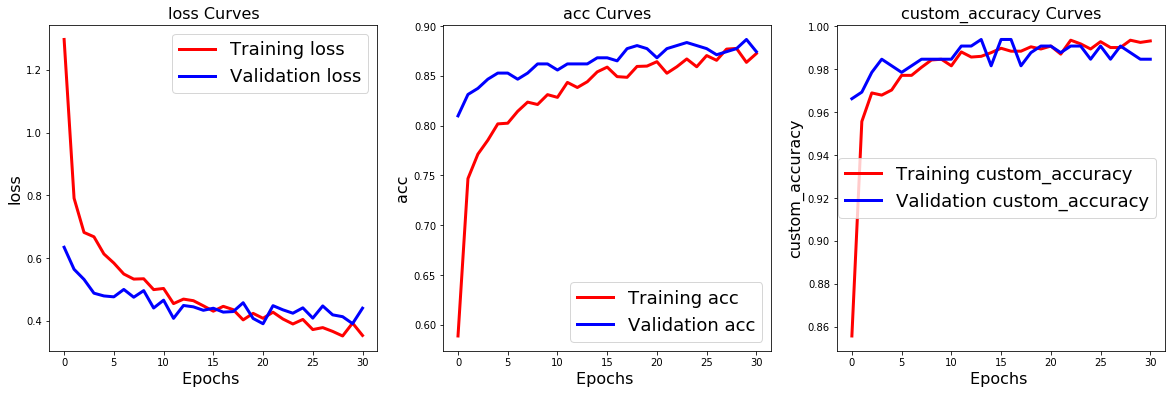

In [86]:
cp_earlystop = EarlyStopping(monitor='val_loss', min_delta=0,
            patience=10, verbose=0, mode='auto')

history = model.model.fit_generator(datagen.flow(X_flickr_subset_train, y_flickr_subset_train, batch_size=32),
                    steps_per_epoch=len(X_flickr_subset_train) / 32, epochs=1000,
                    callbacks=[cp_earlystop],
                    validation_data= (X_flickr_subset_val, y_flickr_subset_val), verbose=1)

plt_history(history)

In [87]:
#evaluate model on test set
print('The accuracy of the model on a test set:')
results = model.model.evaluate(X_flickr_subset_test, y_flickr_subset_test, verbose=0)
print('Accuracy \t:',results[1])
print('Top 4 Accuracy \t:',results[2])

The accuracy of the model on a test set:
Accuracy 	: 0.8618784523800592
Top 4 Accuracy 	: 0.9917127071823204


In [88]:
path_weights = './saved_models/model12/weights.h5'

#Note, cannot save model with this version of Tensorflow
model.model.save_weights(path_weights)

There is no obvious benefit of Image Augmentation based on the results above.